# Calibration of the 9-Mythen detector at the Cristal beamline at Soleil

Mythen detectors are 1D-strip detector sold by Dectris. 
On the Cristal beamline at Soleil, 9 of them are mounted on the goniometer. 

This notebook explains how to calibrate precisely their position (including the wavelength used) as function of the goniometer position.

All input data are provided in a Nexus file wich contrains both the (approximate) energy, the goniometer positions (500 points have been measured) and the measured signal.

As pyFAI is not made for 1D data, the Mythen detector will be considered as a 1x1280 image.

We start by importing a whole bunch of modules:

In [1]:
%matplotlib nbagg
#%config InlineBackend.figure_formats = {'svg',}

In [2]:
import os

from collections import OrderedDict
#import ipympl
from matplotlib import pyplot as plt
import numpy

import h5py

from pyFAI import goniometer
from pyFAI.detectors import Detector
from pyFAI.goniometer import ExtendedTransformation, GoniometerRefinement
from pyFAI.control_points import ControlPoints
from pyFAI.geometryRefinement import GeometryRefinement
from pyFAI.gui import jupyter
from pyFAI.units import hc
from pyFAI.calibrant import get_calibrant
from pyFAI.containers import Integrate1dResult

import ipywidgets as widgets
from IPython.display import display

from scipy.signal import find_peaks_cwt
from scipy.interpolate import interp1d
from scipy.optimize import bisect, minimize
from scipy.spatial import distance_matrix
import time

start_time = time.time()

The data file can be downoaded from:
http://www.silx.org/pub/pyFAI/gonio/LaB6_17keV_att3_tth2C_24_01_2018_19-43-20_1555.nxs

In [3]:
#Open the Nexus file and retrieve the actual positions:

ROOT = "/nfs/ruche-cristal/cristal-soleil/com-cristal/2018/Run1/99180029_Mythen"
filename = os.path.join(ROOT, "LaB6_17keV_att3_tth2C_24_01_2018_19-43-20_1555.nxs")

h5 = h5py.File(filename, mode="r")
position = h5["/LaB6_17keV_att3_1555/scan_data/actuator_1_1"][:]
print("Positions: ", position[:5], "...")

Positions:  [ 90.00000001  89.79994445  89.5998889   89.39994445  89.19994445] ...


In [4]:
#Read all data

data = {}
ds_names = []
for idx in range(1,13):
    name = "data_%02i"%idx
    ds = h5["/LaB6_17keV_att3_1555/scan_data/"+name][:]
    print(name, ds.shape)
    if ds.shape[1]<2000:
        #Keep only the single modules
        data[name] = ds
        ds_names.append(name)

print(ds_names)


data_01 (501, 5120)
data_02 (501, 1280)
data_03 (501, 1280)
data_04 (501, 1280)
data_05 (501, 1280)
data_06 (501, 5120)
data_07 (501, 1280)
data_08 (501, 1280)
data_09 (501, 1280)
data_10 (501, 1280)
data_11 (501, 1280)
data_12 (501, 1280)
['data_02', 'data_03', 'data_04', 'data_05', 'data_07', 'data_08', 'data_09', 'data_10', 'data_11', 'data_12']


In [5]:
#Define a Mythen-detector mounted vertically:

class MythenV(Detector):
    "Verical Mythen dtrip detector from Dectris"
    aliases = ["MythenV 1280"]
    force_pixel = True
    MAX_SHAPE = (1280, 1)

    def __init__(self,pixel1=50e-6, pixel2=8e-3):
        super(MythenV, self).__init__(pixel1=pixel1, pixel2=pixel2)



In [6]:
#Define all modules as single detectors of class MythenV. 
# Each one has a mask defined from dummy-values in the dataset

modules = {}
for name, ds in data.items():
    one_module = MythenV()
    mask = ds[0]<0
    #discard the first 20 and last 20 pixels as their intensities are less reliable
    mask[:20] = True
    mask[-20:] = True
    one_module.mask = mask.reshape(-1,1)
    modules[name] = one_module

for k,v in modules.items():
    print(k, v.name)

data_08 MythenV 1280
data_07 MythenV 1280
data_10 MythenV 1280
data_09 MythenV 1280
data_02 MythenV 1280
data_04 MythenV 1280
data_11 MythenV 1280
data_03 MythenV 1280
data_05 MythenV 1280
data_12 MythenV 1280


In [7]:
# Define a peak-picking function based on the dataset-name and the frame_id:

def peak_picking(module_name, frame_id,  
                 threshold=500):
    """Peak-picking base on find_peaks_cwt from scipy plus 
    second-order tailor exapention refinement for sub-pixel resolution.
    
    The half-pixel offset is accounted here, i.e pixel #0 has its center at 0.5
    
    """
    module = modules[module_name]
    msk = module.mask.ravel()
    
    spectrum = data[module_name][frame_id]
    guess = find_peaks_cwt(spectrum, numpy.array([20]))
    
    valid = numpy.logical_and(numpy.logical_not(msk[guess]), 
                              spectrum[guess] > threshold)
    guess = numpy.extract(valid, guess)
    
    #Based on maximum is f'(x) = 0 ~ f'(x0) + (x-x0)*(f''(x0))
    df = numpy.gradient(spectrum)
    d2f = numpy.gradient(df)
    bad = d2f==0
    d2f[bad] = 1e-10 #prevent devision by zero. Discared later on
    cor = df / d2f
    cor[abs(cor)>1] = 0
    cor[bad] = 0
    ref = guess - cor[guess] + 0.5 #half a pixel offset
    x = numpy.zeros_like(ref) + 0.5 #half a pixel offset
    return numpy.vstack((ref,x)).T

%timeit peak_picking(ds_names[0], 93)
print(peak_picking(ds_names[0], 93))

10 loops, best of 3: 21.4 ms per loop
[[ 287.06072343    0.5       ]]


In [8]:
nrj = h5["/LaB6_17keV_att3_1555/CRISTAL/Monochromator/energy"][0]
wl = hc / nrj *1e-10
print("Energy (keV): ",nrj, "\nWavelength (A): ",wl)

LaB6 = get_calibrant("LaB6")
LaB6.wavelength = wl
print(LaB6)

Energy (keV):  17.0270825492 
Wavelength (A):  7.28158784913e-11
LaB6 Calibrant at wavelength 7.281587849134994e-11


In [9]:
#This cell defines the transformation of coordinates for a simple goniometer mounted vertically.

trans = ExtendedTransformation(dist_expr="dist", 
                                   poni1_expr="poni1", 
                                   poni2_expr="poni2", 
                                   rot1_expr="rot1", 
                                   rot2_expr="pi*(offset+scale*angle)/180.", 
                                   rot3_expr="0.0", 
                                   wavelength_expr="hc/nrj*1e-10", 
                                   param_names=["dist", "poni1", "poni2", "rot1", "offset", "scale", "nrj"], 
                                   pos_names=["angle"], 
                                   constants={"hc": hc})

In [10]:
def get_position(idx):
    "Returns the postion of the goniometer for the given frame_id"
    return position[idx]

#Approximate offset for the module #0 at 0°
print("Approximated offset for the first module: ",get_position(36))

Approximated offset for the first module:  82.7999444511


<IPython.core.display.Javascript object>


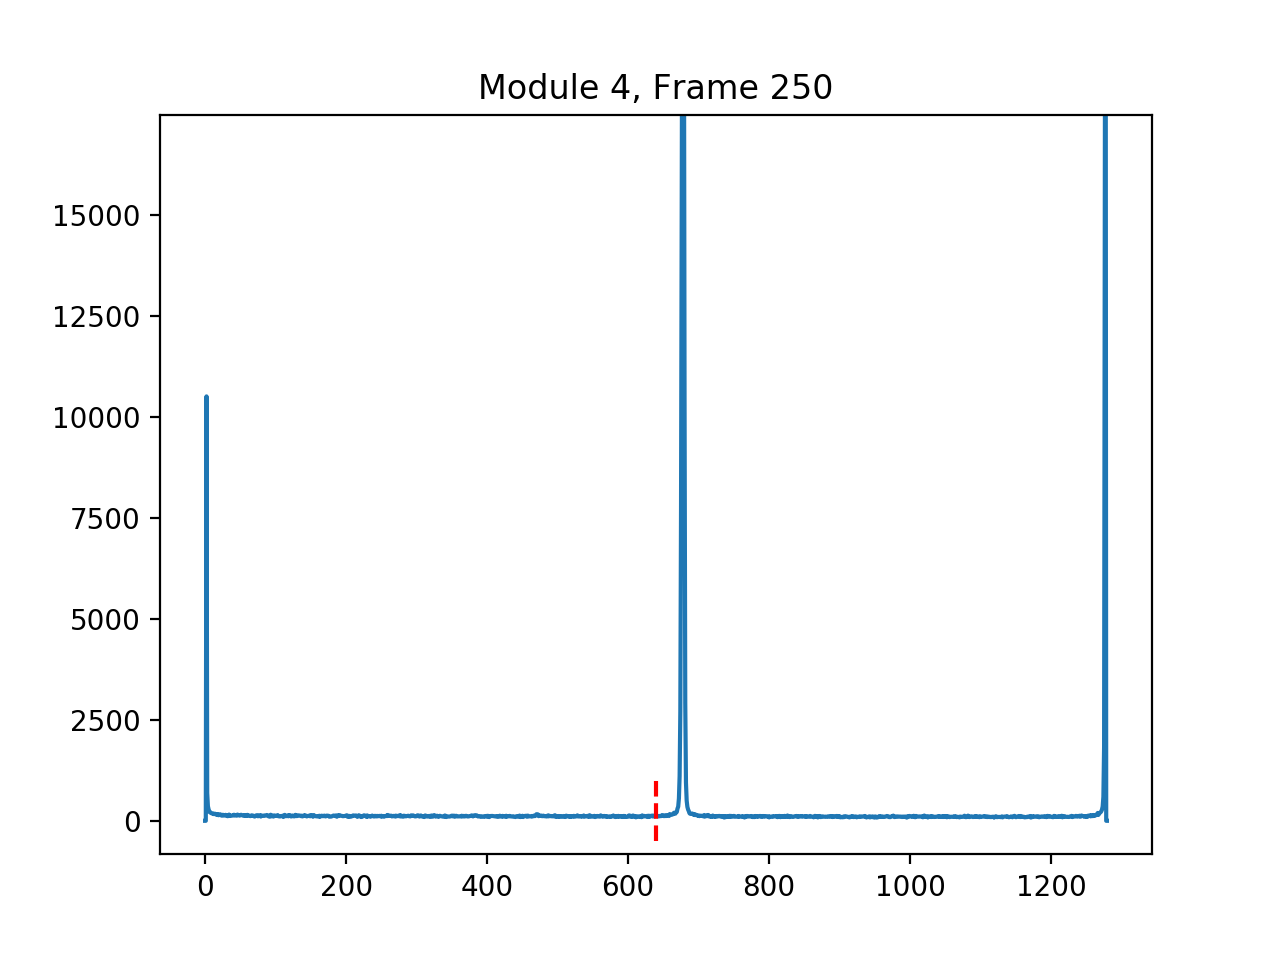

In [11]:
#This interactive plot lets one visualize any spectra acquired by any module

fig, ax = plt.subplots()
line = ax.plot(data[ds_names[0]][250])[0]
ligne = plt.Line2D(xdata=[640,640], ydata=[-500, 1000], figure=fig, linestyle="--", color='red', axes=ax)
ax.add_line(ligne)
ax.set_title("spectrum")
fig.show()

def update(module_id, frame_id):
   spectrum = data[ds_names[module_id]][frame_id]
   line.set_data(numpy.arange(spectrum.size), spectrum)
   ax.set_title("Module %i, Frame %i"%(module_id, frame_id))
   
   fig.canvas.draw()

    
interactive_plot = widgets.interactive(update, 
                                       module_id=(0, len(data)-1), 
                                       frame_id=(0, data[ds_names[0]].shape[0]-1))
display(interactive_plot)

In [12]:
#Work with the first module corresponding to:
name = ds_names[0]
print(name)
ds = data[name]
module = modules[name]

#Use the previous widget to select:
## the index where the beam-center is in the middle of the module
zero_pos = 36

## The frame index where the first LaB6 peak enters the right-hand side of the spectrum
peak_zero_start = 74

## The frame index where this first LaB6 leaves the spectrum or the second LaB6 peak appears:
peak_zero_end = 94

# The frames between peak_zero_start and peak_zero_end will be used to calibrate roughly the goniometer 
# and used later for finer peak extraction

data_02


In [13]:
param0 = {"dist": 0.72, 
          "poni1": 640*50e-6, 
          "poni2": 4e-3, 
          "rot1":0, 
          "offset": -get_position(zero_pos), 
          "scale":1, 
          "nrj": nrj}

#Lock enegy for now and a couple of other parameters
bounds0 = {"nrj": (nrj, nrj),
           "dist": (0.71, 0.73),
           "poni2": (4e-3, 4e-3),
           "rot1": (0,0),
           "scale":(1,1), 
          }

gonioref0 = GoniometerRefinement(param0, 
                                 get_position, 
                                 trans, 
                                 detector=module, 
                                 wavelength=wl, 
                                 bounds=bounds0
                                 )
goniometers = {name:  gonioref0} 
print(gonioref0)

GoniometerRefinement with 0 geometries labeled: .


In [14]:
# Extract the frames where only the peak zero from LaB6 is present.

for i in range(peak_zero_start, peak_zero_end):
    cp = ControlPoints(calibrant=LaB6, wavelength=wl)
    peak = peak_picking(name, i)
    if len(peak)!=1: 
        continue
    cp.append([peak[0]], ring=0)
    img = ds[i].reshape((-1,1)) #Images are vertical ... transpose the spectrum
    sg = gonioref0.new_geometry("%s_%04i"%(name,i), 
                                image=img, 
                                metadata=i, 
                                control_points=cp, 
                                calibrant=LaB6)
    sg.geometry_refinement.data = numpy.array(cp.getList())

print(gonioref0)
print("Residual error before fit:")
print(gonioref0.chi2())

GoniometerRefinement with 20 geometries labeled: data_02_0074, data_02_0075, data_02_0076, data_02_0077, data_02_0078, data_02_0079, data_02_0080, data_02_0081, data_02_0082, data_02_0083, data_02_0084, data_02_0085, data_02_0086, data_02_0087, data_02_0088, data_02_0089, data_02_0090, data_02_0091, data_02_0092, data_02_0093.
Residual error before fit:
6.73738433628e-07


In [15]:
#First refinement:
gonioref0.refine2()

Cost function before refinement: 6.73738433628e-07
[  7.20000000e-01   3.20000000e-02   4.00000000e-03   0.00000000e+00
  -8.27999445e+01   1.00000000e+00   1.70270825e+01]
     fun: 2.4909887983915309e-11
     jac: array([  1.58414573e-07,   2.91897065e-08,   5.74391333e-11,
        -6.39962716e-10,   3.42479452e-11,   1.40698490e-07,
        -1.59997085e-11,   0.00000000e+00])
 message: 'Optimization terminated successfully.'
    nfev: 19
     nit: 2
    njev: 2
  status: 0
 success: True
       x: array([  7.19994724e-01,   3.14085784e-02,   4.00000000e-03,
         0.00000000e+00,  -8.27999519e+01,   1.00000000e+00,
         1.70270825e+01])
Cost function after refinement: 2.49098879839e-11
GonioParam(dist=0.71999472436836631, poni1=0.031408578351606029, poni2=0.0040000000000000001, rot1=0.0, offset=-82.799951886585703, scale=1.0, nrj=17.027082549190933)
maxdelta on: poni1 (1) 0.032 --> 0.0314085783516


array([  7.19994724e-01,   3.14085784e-02,   4.00000000e-03,
         0.00000000e+00,  -8.27999519e+01,   1.00000000e+00,
         1.70270825e+01])

In [16]:
#Here we extract all spectra for peaks,
# If there are as many peaks as expected from the theoritical LaB6. perform the assignment.

#Peaks from LaB6:
tths = LaB6.get_2th()

for i in range(peak_zero_end, ds.shape[0]):
    peak = peak_picking(name, i)
    ai=gonioref0.get_ai(get_position(i))
    tth = ai.array_from_unit(unit="2th_rad", scale=False)
    tth_low = tth[20]
    tth_hi = tth[-20]
    ttmin, ttmax = min(tth_low, tth_hi), max(tth_low, tth_hi)
    valid_peaks = numpy.logical_and(ttmin<=tths, tths<ttmax)
    cnt = valid_peaks.sum()
    if (len(peak) ==  cnt):    
        cp = ControlPoints(calibrant=LaB6, wavelength=wl)
        #revert the order of assignment if needed !!
        if tth_hi < tth_low:
            peak = peak[-1::-1]
        for p, r in zip(peak, numpy.where(valid_peaks)[0]):
            #print(p,r)
            cp.append([p], ring=r)
        img = ds[i].reshape((-1,1))
        sg = gonioref0.new_geometry("%s_%04i"%(name,i), 
                                    image=img, 
                                    metadata=i, 
                                    control_points=cp, 
                                    calibrant=LaB6)
        sg.geometry_refinement.data = numpy.array(cp.getList())
        #print(sg.label, len(sg.geometry_refinement.data))

#print(gonioref0)
print(" Number of peaks found and used for refinement")
print(sum([len(sg.geometry_refinement.data) for sg in gonioref0.single_geometries.values()]))
print("Residual error before fitting: ", gonioref0.chi2())

 Number of peaks found and used for refinement
1203
Residual error before fitting:  3.11867280944e-06


In [17]:
gonioref0.refine2()

Cost function before refinement: 3.11867280944e-06
[  7.19994724e-01   3.14085784e-02   4.00000000e-03   0.00000000e+00
  -8.27999519e+01   1.00000000e+00   1.70270825e+01]
     fun: 2.7342504326784721e-06
     jac: array([ -5.58224542e-08,  -3.65304231e-10,   3.63058044e-06,
        -2.62495314e-06,   6.31729336e-10,   1.53969062e-04,
         9.87797637e-06,   0.00000000e+00])
 message: 'Optimization terminated successfully.'
    nfev: 65
     nit: 7
    njev: 7
  status: 0
 success: True
       x: array([  7.23095347e-01,   3.18453768e-02,   4.00000000e-03,
         0.00000000e+00,  -8.27999466e+01,   1.00000000e+00,
         1.70270825e+01])
Cost function after refinement: 2.73425043268e-06
GonioParam(dist=0.72309534674940268, poni1=0.03184537681912273, poni2=0.0040000000000000001, rot1=0.0, offset=-82.799946616943757, scale=1.0, nrj=17.027082549190933)
maxdelta on: dist (0) 0.719994724368 --> 0.723095346749


array([  7.23095347e-01,   3.18453768e-02,   4.00000000e-03,
         0.00000000e+00,  -8.27999466e+01,   1.00000000e+00,
         1.70270825e+01])

In [18]:
gonioref0.set_bounds("poni1", -1, 1)
gonioref0.set_bounds("poni2", -1, 1)
gonioref0.set_bounds("rot1", -1, 1)
gonioref0.set_bounds("scale", 0.9, 1.1)
gonioref0.refine2()

Cost function before refinement: 2.73425043268e-06
[  7.23095347e-01   3.18453768e-02   4.00000000e-03   0.00000000e+00
  -8.27999466e+01   1.00000000e+00   1.70270825e+01]
     fun: 2.6891723022540698e-06
     jac: array([ -5.14464347e-07,  -1.24120874e-07,   5.95670514e-07,
        -4.28660144e-07,  -9.28110921e-10,  -8.53860058e-08,
        -1.60467593e-06,   0.00000000e+00])
 message: 'Optimization terminated successfully.'
    nfev: 36
     nit: 4
    njev: 4
  status: 0
 success: True
       x: array([  7.23096248e-01,   3.20537111e-02,   3.98485468e-03,
         1.09479202e-05,  -8.27999440e+01,   9.99415047e-01,
         1.70270825e+01])
Cost function after refinement: 2.68917230225e-06
GonioParam(dist=0.72309624843476161, poni1=0.032053711099507581, poni2=0.0039848546794088863, rot1=1.0947920188414968e-05, offset=-82.799943989630094, scale=0.99941504702634443, nrj=17.027082549190933)
maxdelta on: scale (5) 1.0 --> 0.999415047026


array([  7.23096248e-01,   3.20537111e-02,   3.98485468e-03,
         1.09479202e-05,  -8.27999440e+01,   9.99415047e-01,
         1.70270825e+01])

In [19]:
# Perform the azimuthal intgration of all data for the first module:

mg = gonioref0.get_mg(position)
mg.radial_range = (0, 95)
images = [i.reshape(-1, 1) for i in ds]
res_mg = mg.integrate1d(images, 50000)
results={name: res_mg}
print(results)

{'data_02': (array([  9.50000113e-04,   2.85000011e-03,   4.75000011e-03, ...,
         9.49952500e+01,   9.49971500e+01,   9.49990500e+01]), array([  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
         1.27163417e+08,   1.30591594e+08,   1.33665235e+08]))}


<IPython.core.display.Javascript object>


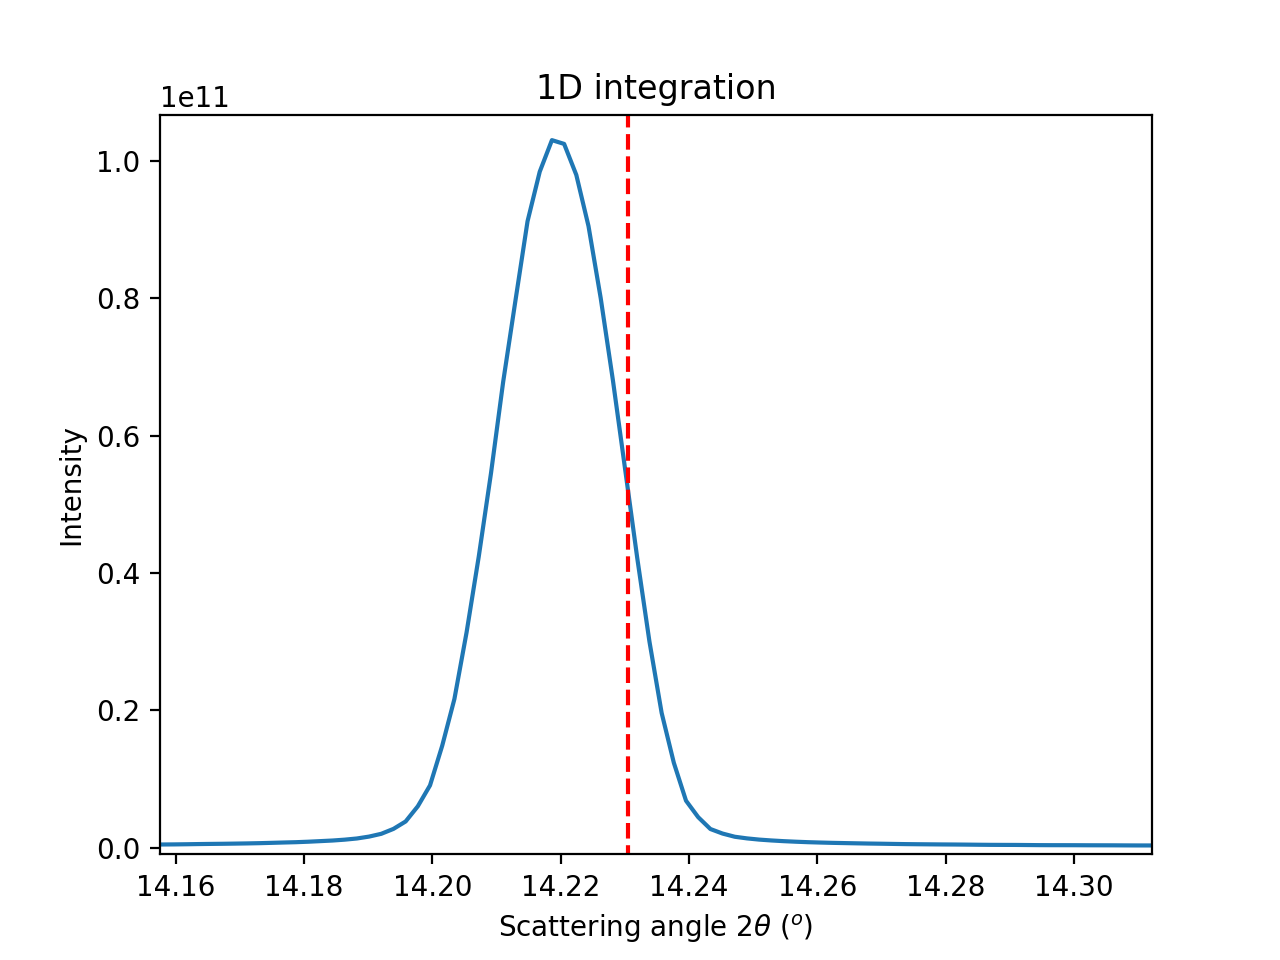

In [20]:
# Plot the integrated pattern vs expected peak positions:

LaB6_new = get_calibrant("LaB6")
LaB6_new.wavelength = hc/gonioref0.param[-1]*1e-10
p = jupyter.plot1d(res_mg, calibrant=LaB6_new)
p.figure.show()

In [21]:
#Peak profile function based on a bilinear interpolations: 

def calc_fwhm(integrate_result, calibrant, tth_min=None, tth_max=None):
    "calculate the tth position and FWHM for each peak"
    delta = integrate_result.intensity[1:] - integrate_result.intensity[:-1]
    maxima = numpy.where(numpy.logical_and(delta[:-1]>0, delta[1:]<0))[0]
    minima = numpy.where(numpy.logical_and(delta[:-1]<0, delta[1:]>0))[0]
    maxima += 1
    minima += 1
    tth = []
    FWHM = []
    if tth_min is None:
        tth_min = integrate_result.radial[0]
    if tth_max is None:
        tth_max = integrate_result.radial[-1]
    for tth_rad in calibrant.get_2th():
        tth_deg = tth_rad*integrate_result.unit.scale
        if (tth_deg<=tth_min) or (tth_deg>=tth_max):
            continue
        idx_theo = abs(integrate_result.radial-tth_deg).argmin()
        id0_max = abs(maxima-idx_theo).argmin()
        id0_min = abs(minima-idx_theo).argmin()
        I_max = integrate_result.intensity[maxima[id0_max]]
        I_min = integrate_result.intensity[minima[id0_min]]
        tth_maxi = integrate_result.radial[maxima[id0_max]]
        I_thres = (I_max + I_min)/2.0
        if minima[id0_min]>maxima[id0_max]:
            if id0_min == 0:
                min_lo = integrate_result.radial[0]
            else:
                min_lo = integrate_result.radial[minima[id0_min-1]]
            min_hi = integrate_result.radial[minima[id0_min]]
        else:
            if id0_min == len(minima) -1:
                min_hi = integrate_result.radial[-1]
            else:
                min_hi = integrate_result.radial[minima[id0_min+1]]
            min_lo = integrate_result.radial[minima[id0_min]]
            
        f = interp1d(integrate_result.radial, integrate_result.intensity-I_thres)
        try:
            tth_lo = bisect(f, min_lo, tth_maxi)
            tth_hi = bisect(f, tth_maxi, min_hi)
        except:
            pass
        else:
            FWHM.append(tth_hi-tth_lo)
            tth.append(tth_deg)
    return tth, FWHM
    


In [22]:
# Peak error:

def calc_peak_error(integrate_result, calibrant, tth_min=10, tth_max=95):
    "calculate the tth position and FWHM for each peak"
    peaks = find_peaks_cwt(integrate_result.intensity, numpy.array([10]))
    df = numpy.gradient(integrate_result.intensity)
    d2f = numpy.gradient(df)
    bad = d2f==0
    d2f[bad] = 1e-10
    cor = df / d2f
    print((abs(cor)>1).sum())
    cor[abs(cor)>1] = 0
    cor[bad] = 0
    got = numpy.interp(peaks-cor[peaks], 
                       numpy.arange(len(integrate_result.radial)), 
                       integrate_result.radial)
    mask = numpy.logical_and(got>=tth_min,
                             got<=tth_max)
    got = got[mask]
    target = numpy.array(calibrant.get_2th())*integrate_result.unit.scale
    mask = numpy.logical_and(target>=tth_min,
                             target<=tth_max)
    target = target[mask]
    print(len(got), len(target))
    d2 = distance_matrix(target.reshape(-1, 1 ),
                         got.reshape(-1, 1), p=1)
    
    return target, target-got[d2.argmin(axis=-1)]


<IPython.core.display.Javascript object>


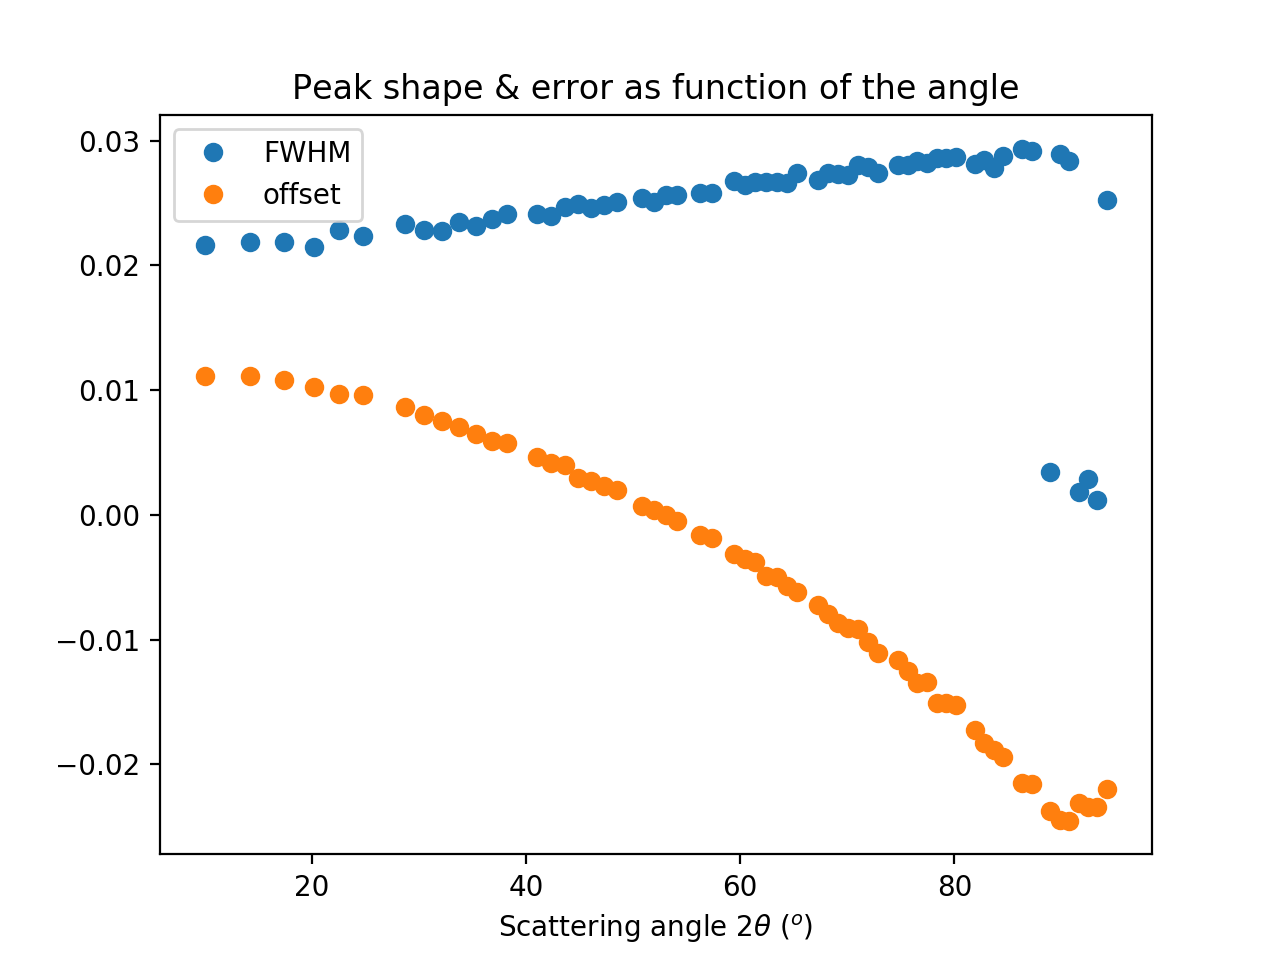

29209
81 60


In [23]:
fig, ax = plt.subplots()
ax.plot(*calc_fwhm(res_mg, LaB6_new), "o", label="FWHM")
ax.plot(*calc_peak_error(res_mg, LaB6_new), "o", label="offset")
ax.set_title("Peak shape & error as function of the angle")
ax.set_xlabel(res_mg.unit.label)
ax.legend()
fig.show()

## Module 1 

We can apply the same procdure for the second module ... and try to rationalize the procedure.

In [24]:
module_id = 1
name = ds_names[module_id]
ds = data[name]
zero_pos = 64
frame_start = 103
frame_stop = 123

In [25]:
param1 = {"dist": 0.72, 
          "poni1": 640*50e-6, 
          "poni2": 4e-3, 
          "rot1":0, 
          "offset": -get_position(zero_pos), 
          "scale":1, 
          "nrj": nrj}

#Lock enegy for now and a couple of other parameters
bounds1 = {"nrj": (nrj, nrj),
           "dist": (0.7, 0.8),
           "poni2": (4e-3, 4e-3),
           "rot1": (0,0),
           "scale":(1,1), }

gonioref1 = GoniometerRefinement(param1, 
                                 get_position, 
                                 trans, 
                                 detector=modules[name], 
                                 wavelength=wl, 
                                 bounds=bounds1
                                 )
print(gonioref1)
goniometers[name]=gonioref1

GoniometerRefinement with 0 geometries labeled: .


In [26]:
#Exctract frames with peak#0
for i in range(frame_start, frame_stop):
    cp = ControlPoints(calibrant=LaB6, wavelength=wl)
    peak = peak_picking(name, i)
    if len(peak)!=1: 
        continue
    cp.append([peak[0]], ring=0)
    img = (ds[i]).reshape((-1,1))
    sg = gonioref1.new_geometry("%s_%04i"%(name,i), 
                                image=img, 
                                metadata=i, 
                                control_points=cp, 
                                calibrant=LaB6)
    sg.geometry_refinement.data = numpy.array(cp.getList())

print(gonioref1)
print(gonioref1.chi2())

GoniometerRefinement with 20 geometries labeled: data_03_0103, data_03_0104, data_03_0105, data_03_0106, data_03_0107, data_03_0108, data_03_0109, data_03_0110, data_03_0111, data_03_0112, data_03_0113, data_03_0114, data_03_0115, data_03_0116, data_03_0117, data_03_0118, data_03_0119, data_03_0120, data_03_0121, data_03_0122.
1.45247002028e-06


In [27]:
gonioref1.refine2()

Cost function before refinement: 1.45247002028e-06
[  7.20000000e-01   3.20000000e-02   4.00000000e-03   0.00000000e+00
  -7.72000000e+01   1.00000000e+00   1.70270825e+01]
     fun: 2.3431861472723482e-11
     jac: array([  1.37377624e-07,   1.03462536e-07,   2.38592839e-09,
        -2.23238045e-09,   9.89688559e-10,   1.85837277e-07,
        -5.81633804e-10,   0.00000000e+00])
 message: 'Optimization terminated successfully.'
    nfev: 19
     nit: 2
    njev: 2
  status: 0
 success: True
       x: array([  7.20006378e-01,   3.28683965e-02,   4.00000000e-03,
         0.00000000e+00,  -7.71999891e+01,   1.00000000e+00,
         1.70270825e+01])
Cost function after refinement: 2.34318614727e-11
GonioParam(dist=0.7200063780313144, poni1=0.032868396513979561, poni2=0.0040000000000000001, rot1=0.0, offset=-77.199989088502662, scale=1.0, nrj=17.027082549190933)
maxdelta on: poni1 (1) 0.032 --> 0.032868396514


array([  7.20006378e-01,   3.28683965e-02,   4.00000000e-03,
         0.00000000e+00,  -7.71999891e+01,   1.00000000e+00,
         1.70270825e+01])

In [28]:
#Exctract all frames with peak>0
tths = LaB6.get_2th()
#print(tths)
for i in range(frame_stop, ds.shape[0]):
    frame_name = "%s_%04i"%(name, i)
    if frame_name in gonioref1.single_geometries:
        continue
    peak = peak_picking(name, i)
    ai=gonioref1.get_ai(get_position(i))
    tth = ai.array_from_unit(unit="2th_rad", scale=False)
    tth_low = tth[20]
    tth_hi = tth[-20]
    ttmin, ttmax = min(tth_low, tth_hi), max(tth_low, tth_hi)
    valid_peaks = numpy.logical_and(ttmin<=tths, tths<ttmax)
    cnt = valid_peaks.sum()
    if (len(peak) ==  cnt) and cnt>0:    
        cp = ControlPoints(calibrant=LaB6, wavelength=wl)
        #revert the order of assignment if needed !!
        if tth_hi < tth_low:
            peak = peak[-1::-1]
        for p, r in zip(peak, numpy.where(valid_peaks)[0]):
            cp.append([p], ring=r)
        img = ds[i].reshape((-1,1))
        sg = gonioref1.new_geometry(frame_name, 
                                    image=img, 
                                    metadata=i, 
                                    control_points=cp, 
                                    calibrant=LaB6)
        sg.geometry_refinement.data = numpy.array(cp.getList())
        #print(frame_name, len(sg.geometry_refinement.data))

print(" Number of peaks found and used for refinement")
print(sum([len(sg.geometry_refinement.data) for sg in gonioref1.single_geometries.values()]))
print("Residual error before fitting: ", gonioref1.chi2())

 Number of peaks found and used for refinement
1183
Residual error before fitting:  6.33476997362e-07


In [29]:
gonioref1.refine2()
gonioref1.set_bounds("poni1", -1, 1)
gonioref1.set_bounds("poni2", -1, 1)
gonioref1.set_bounds("rot1", -1, 1)
gonioref1.set_bounds("scale", 0.9, 1.1)
gonioref1.refine2()

Cost function before refinement: 6.33476997362e-07
[  7.20006378e-01   3.28683965e-02   4.00000000e-03   0.00000000e+00
  -7.71999891e+01   1.00000000e+00   1.70270825e+01]
     fun: 1.3797542164386038e-07
     jac: array([ -4.62580205e-07,   2.40834463e-08,   5.10766142e-06,
        -3.67570741e-06,   1.35589318e-11,   2.65546301e-04,
         1.99388955e-05,   0.00000000e+00])
 message: 'Optimization terminated successfully.'
    nfev: 19
     nit: 2
    njev: 2
  status: 0
 success: True
       x: array([  7.20006340e-01,   3.33754761e-02,   4.00000000e-03,
         0.00000000e+00,  -7.71999827e+01,   1.00000000e+00,
         1.70270825e+01])
Cost function after refinement: 1.37975421644e-07
GonioParam(dist=0.72000633950011639, poni1=0.033375476115602126, poni2=0.0040000000000000001, rot1=0.0, offset=-77.199982712322154, scale=1.0, nrj=17.027082549190933)
maxdelta on: poni1 (1) 0.032868396514 --> 0.0333754761156
Cost function before refinement: 1.37975421644e-07
[  7.20006340e-01   

array([  7.20682081e-01,   3.36782425e-02,   4.05801126e-03,
        -4.44860018e-05,  -7.71999788e+01,   9.98967223e-01,
         1.70270825e+01])

In [30]:
mg1 = gonioref1.get_mg(position)
mg1.radial_range = (0, 95)
images = [i.reshape(-1, 1) for i in data[name]]
res_mg1 = mg1.integrate1d(images, 50000)
results[name] = res_mg1

area_pixel=0.04011793214486481 area_sum=0.05472285778563535, Error= -0.3640498116411517
area_pixel=0.06755918226705582 area_sum=0.07017344439747103, Error= -0.038695881783785545
area_pixel=0.06470384723321665 area_sum=0.06854713835898787, Error= -0.05939818558112286
area_pixel=0.038258287348172715 area_sum=0.05426051394830549, Error= -0.4182682422373795
area_pixel=0.06290299608614092 area_sum=0.06750646087344028, Error= -0.07318355362589196
area_pixel=0.06866181632504009 area_sum=0.0710979827571788, Error= -0.03548065813764767
area_pixel=0.045481003274128184 area_sum=0.05690843539150094, Error= -0.2512572567604998
area_pixel=0.051372066242729275 area_sum=0.060437735665688296, Error= -0.17647079601829507
area_pixel=0.08412331180916155 area_sum=0.08447601010651973, Error= -0.004192634476377893
area_pixel=0.07467387290401106 area_sum=0.07603231757541912, Error= -0.018191699701370204
area_pixel=0.0624099895059711 area_sum=0.0673026438866445, Error= -0.07839537259023732
area_pixel=0.0419590

<IPython.core.display.Javascript object>


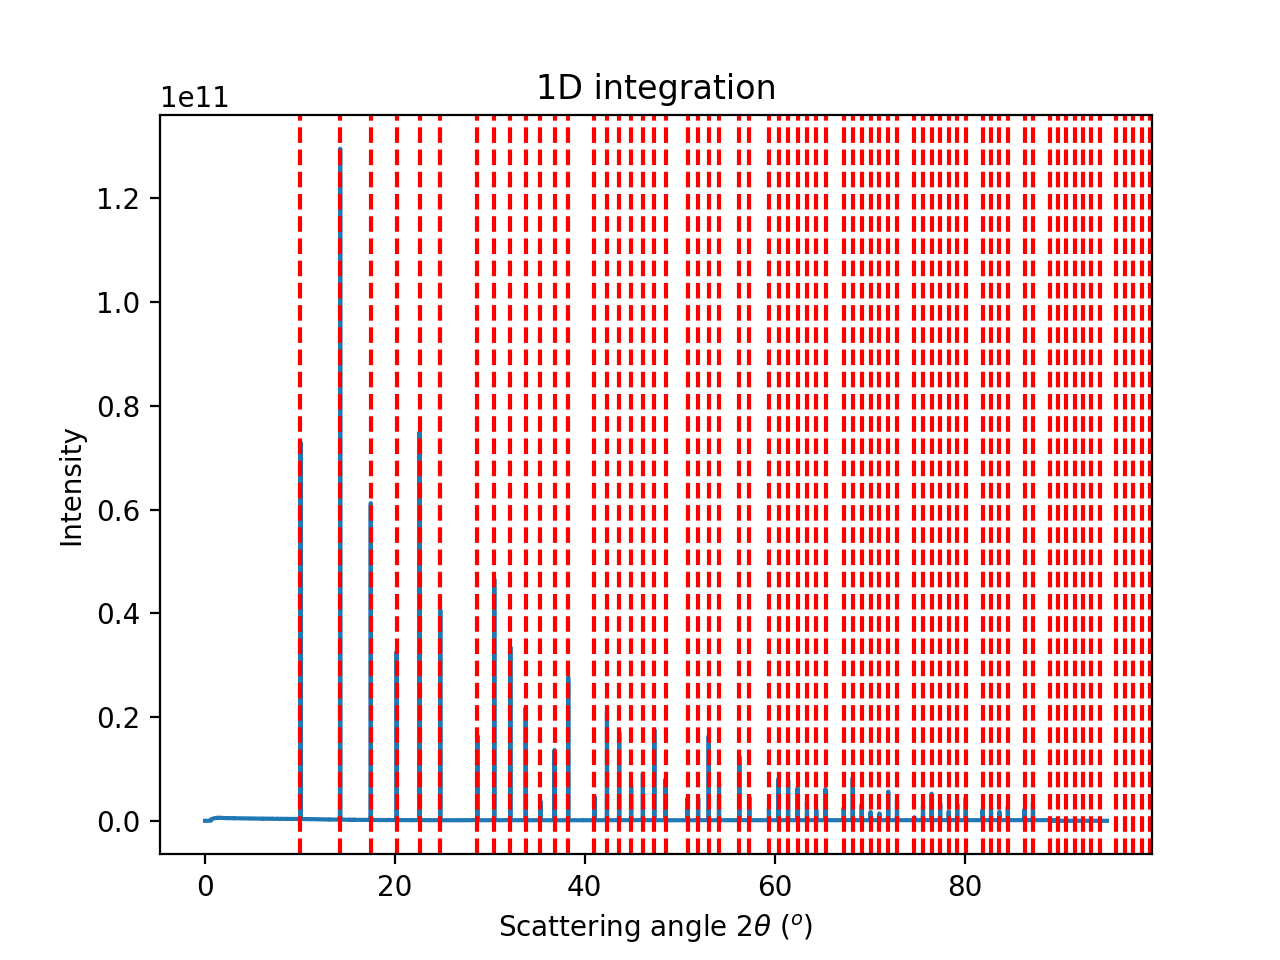

In [31]:
LaB6_new = get_calibrant("LaB6")
LaB6_new.wavelength = hc/gonioref1.param[-1]*1e-10
p = jupyter.plot1d(res_mg1, calibrant=LaB6_new)
p.figure.show()

<IPython.core.display.Javascript object>


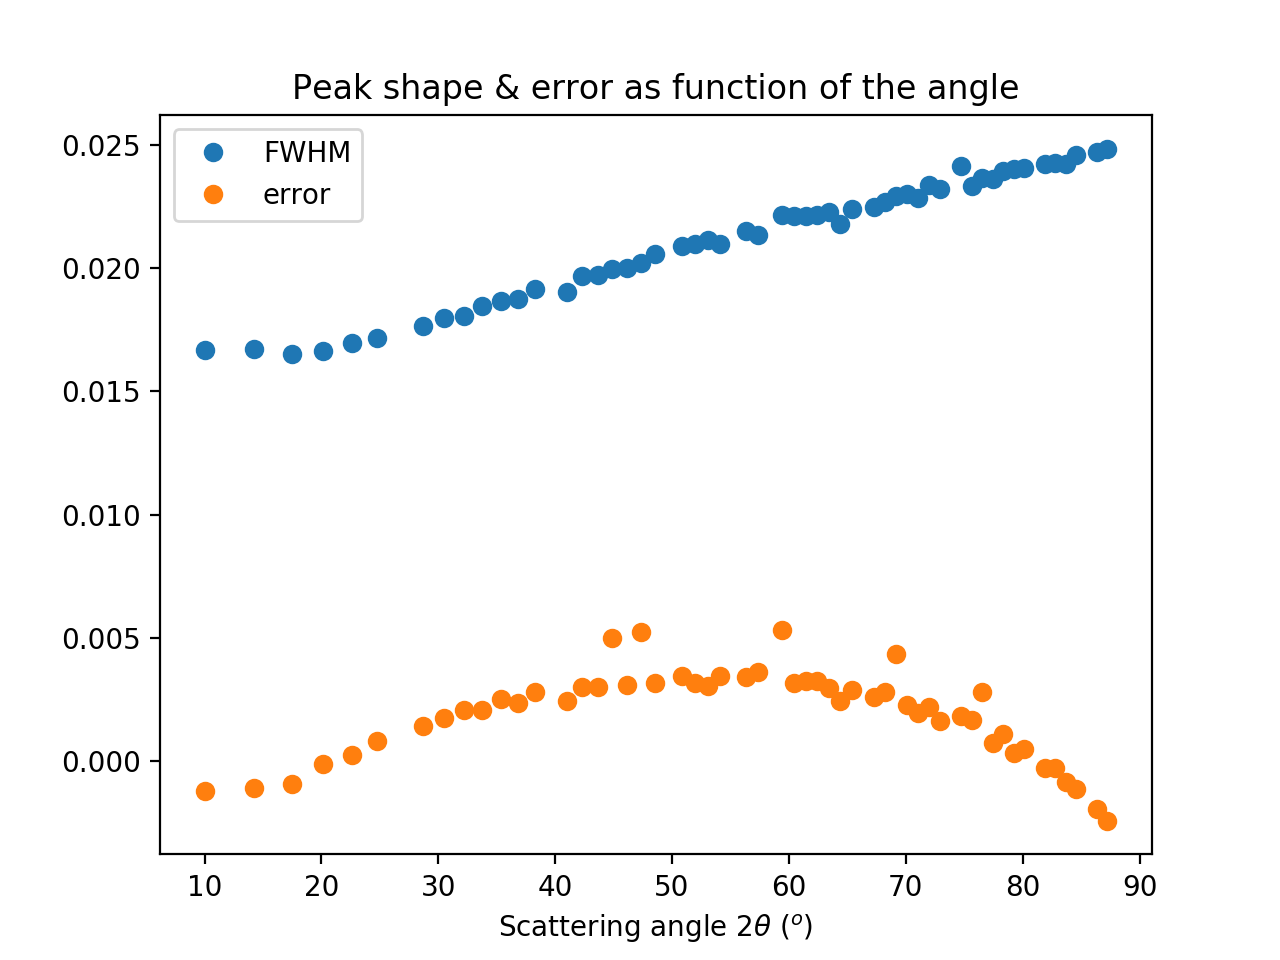

27712
72 53


In [32]:
fig, ax = plt.subplots()
ax.plot(*calc_fwhm(res_mg1, LaB6_new, 10, 88), "o", label="FWHM")
ax.plot(*calc_peak_error(res_mg1, LaB6_new, 10, 88), "o", label="error")
ax.set_title("Peak shape & error as function of the angle")
ax.set_xlabel(res_mg.unit.label)
ax.legend()
fig.show()

## All other Modules

We define now an automatic procedure for any module. 
The detection used 3 parameter visually extracted from the Figure1: 

* zero_pos: the frame where the beam-stop is in the center of the module
* frame_start: the frame where the first peak of LaB6 appears (positive)
* frame_stop: the frame where the second peak of LaB6 appears (positive)

This is enough for boot-strapping the goniometer configuration.

In [33]:
def add_module(name,
               zero_pos,
               frame_start,
               frame_stop,
                ):
    ds = data[name]
    param = {"dist": 0.72, 
          "poni1": 640*50e-6, 
          "poni2": 4e-3, 
          "rot1":0, 
          "offset": -get_position(zero_pos), 
          "scale":1, 
          "nrj": nrj}

    #Lock enegy for now and a couple of other parameters
    bounds = {"nrj": (nrj, nrj),
              "dist": (0.7, 0.8),
              "poni2": (4e-3, 4e-3),
              "rot1": (0,0),
              "scale": (1,1)}

    gonioref = GoniometerRefinement(param, 
                                    get_position, 
                                    trans, 
                                    detector=modules[name], 
                                    wavelength=wl, 
                                    bounds=bounds
                                      )
    goniometers[name] = gonioref
    
    for i in range(frame_start, frame_stop):
        cp = ControlPoints(calibrant=LaB6, wavelength=wl)
        peak = peak_picking(name, i)
        if len(peak)!=1: 
            continue
        cp.append([peak[0]], ring=0)
        img = (ds[i]).reshape((-1,1))
        sg = gonioref.new_geometry("%s_%04i"%(name, i), 
                                    image=img, 
                                    metadata=i, 
                                    control_points=cp, 
                                    calibrant=LaB6)
        sg.geometry_refinement.data = numpy.array(cp.getList())

    print(gonioref.chi2())
    gonioref.refine2()
        
    tths = LaB6.get_2th()
    #print(tths)
    for i in range(frame_stop, ds.shape[0]):
        frame_name = "%s_%04i"%(name, i)
        if frame_name in gonioref.single_geometries:
            continue
        peak = peak_picking(name, i)
        ai=gonioref.get_ai(get_position(i))
        tth = ai.array_from_unit(unit="2th_rad", scale=False)
        tth_low = tth[20]
        tth_hi = tth[-20]
        ttmin, ttmax = min(tth_low, tth_hi), max(tth_low, tth_hi)
        valid_peaks = numpy.logical_and(ttmin<=tths, tths<ttmax)
        cnt = valid_peaks.sum()
        if (len(peak) ==  cnt) and cnt>0:    
            cp = ControlPoints(calibrant=LaB6, wavelength=wl)
            #revert the order of assignment if needed !!
            if tth_hi < tth_low:
                peak = peak[-1::-1]

            for p, r in zip(peak, numpy.where(valid_peaks)[0]):
                cp.append([p], ring=r)
            img = (ds[i]).reshape((-1,1))
            sg = gonioref.new_geometry(frame_name, 
                                        image=img, 
                                        metadata=i, 
                                        control_points=cp, 
                                        calibrant=LaB6)
            sg.geometry_refinement.data = numpy.array(cp.getList())
            #print(frame_name, len(sg.geometry_refinement.data))


    print(" Number of peaks found and used for refinement")
    print(sum([len(sg.geometry_refinement.data) for sg in gonioref.single_geometries.values()]))

    gonioref.refine2()
    gonioref.set_bounds("poni1", -1, 1)
    gonioref.set_bounds("poni2", -1, 1)
    gonioref.set_bounds("rot1", -1, 1)
    gonioref.set_bounds("scale", 0.9, 1.1)
    gonioref.refine2()
    
    mg = gonioref.get_mg(position)
    mg.radial_range = (0, 95)
    images = [i.reshape(-1, 1) for i in ds]
    res_mg = mg.integrate1d(images, 50000)
    results[name] = res_mg
    
    LaB6_new = get_calibrant("LaB6")
    LaB6_new.wavelength = hc/gonioref.param[-1]*1e-10
    p = jupyter.plot1d(res_mg, calibrant=LaB6_new)
    p.figure.show()
    
    fig, ax = plt.subplots()
    ax.plot(*calc_fwhm(res_mg, LaB6_new), "o", label="FWHM")
    ax.plot(*calc_peak_error(res_mg, LaB6_new, 10, 89), "o", label="error")
    ax.set_title("Peak shape & error as function of the angle")
    ax.set_xlabel(res_mg.unit.label)
    ax.legend()
    fig.show()

8.4063387717e-06
Cost function before refinement: 8.4063387717e-06
[  7.20000000e-01   3.20000000e-02   4.00000000e-03   0.00000000e+00
  -7.15999445e+01   1.00000000e+00   1.70270825e+01]
     fun: 1.8085720026529708e-11
     jac: array([  4.57424569e-08,   8.17041295e-07,   2.47626008e-08,
        -1.79775418e-08,   9.91633086e-09,   6.60392633e-07,
        -5.86643086e-09,   0.00000000e+00])
 message: 'Optimization terminated successfully.'
    nfev: 19
     nit: 2
    njev: 2
  status: 0
 success: True
       x: array([  7.20018961e-01,   3.40893083e-02,   4.00000000e-03,
         0.00000000e+00,  -7.15999182e+01,   1.00000000e+00,
         1.70270825e+01])
Cost function after refinement: 1.80857200265e-11
GonioParam(dist=0.7200189605020697, poni1=0.034089308326420362, poni2=0.0040000000000000001, rot1=0.0, offset=-71.599918182298367, scale=1.0, nrj=17.027082549190933)
maxdelta on: poni1 (1) 0.032 --> 0.0340893083264
 Number of peaks found and used for refinement
1093
Cost function

<IPython.core.display.Javascript object>


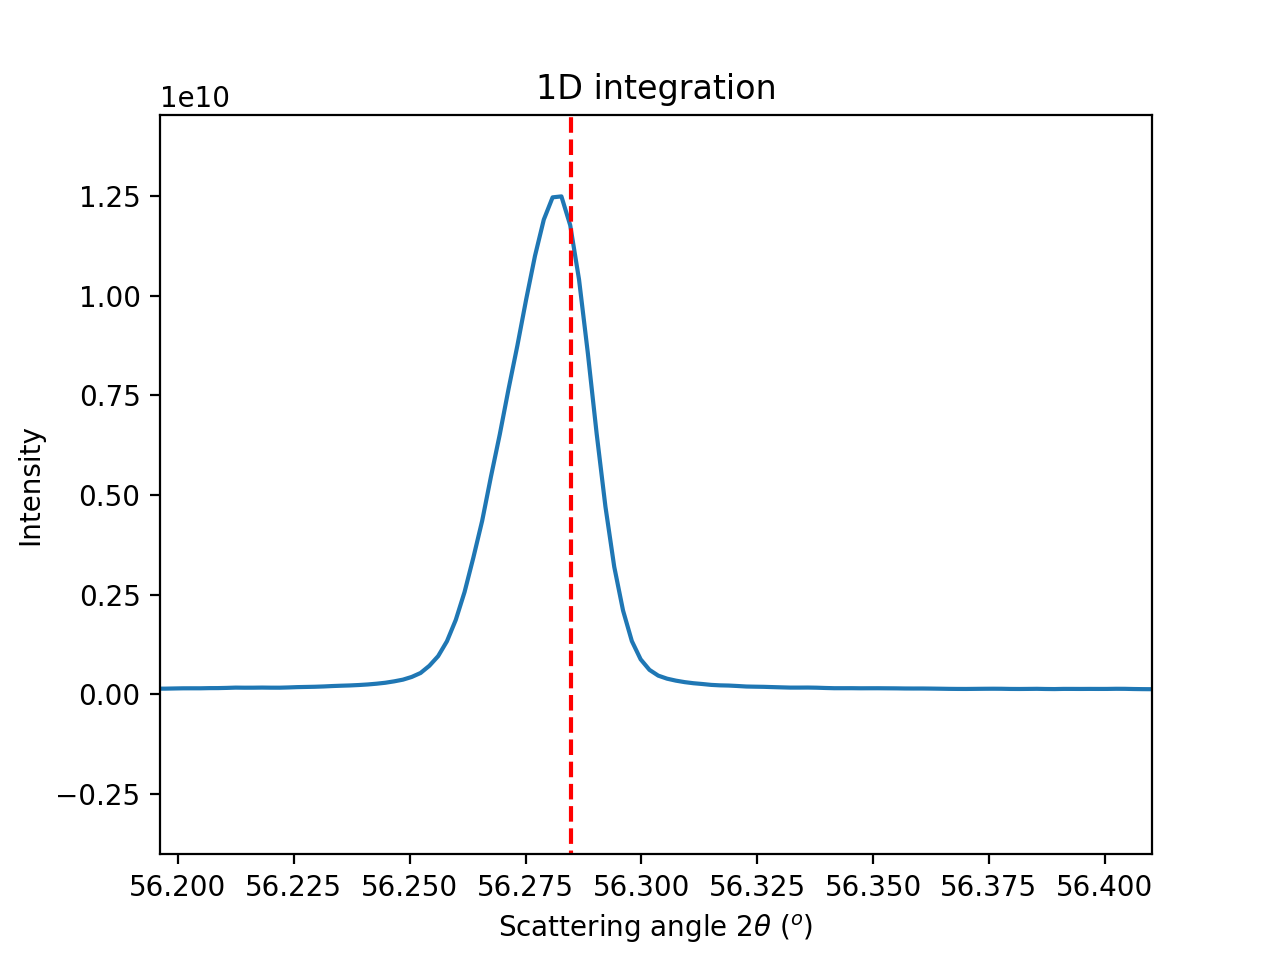

<IPython.core.display.Javascript object>


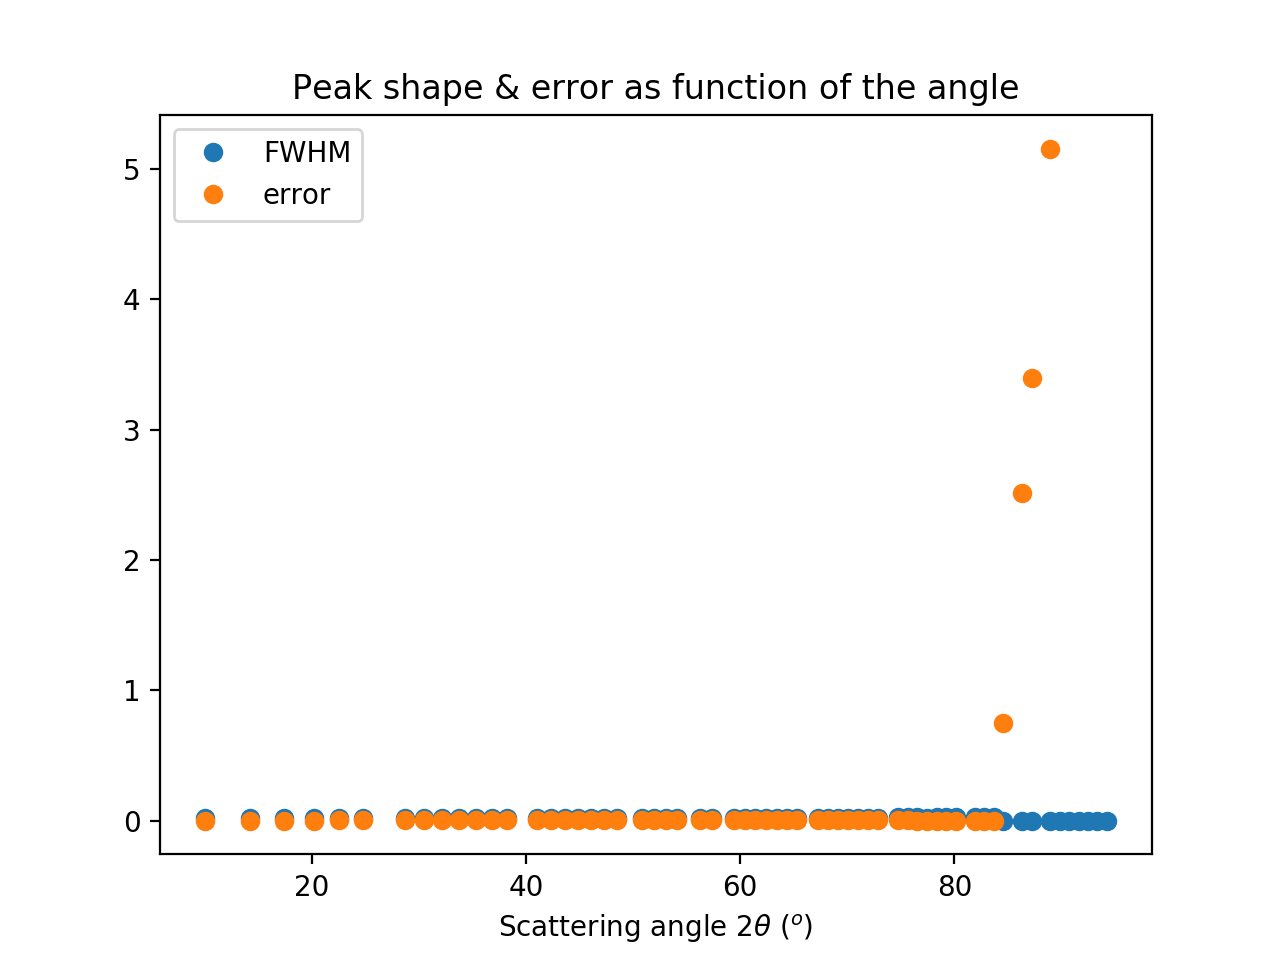

25667
71 54


In [34]:
add_module(ds_names[2],
           92,
           131,
           151)

1.08254084413e-06
Cost function before refinement: 1.08254084413e-06
[  7.20000000e-01   3.20000000e-02   4.00000000e-03   0.00000000e+00
  -6.57999444e+01   1.00000000e+00   1.70270825e+01]
     fun: 2.4921939380829473e-11
     jac: array([ -8.60015175e-08,   7.99451827e-08,   1.64794931e-09,
        -8.07493243e-10,   6.18853503e-10,  -1.33401994e-08,
        -3.62117520e-10,   0.00000000e+00])
 message: 'Optimization terminated successfully.'
    nfev: 19
     nit: 2
    njev: 2
  status: 0
 success: True
       x: array([  7.20006745e-01,   3.27496622e-02,   4.00000000e-03,
         0.00000000e+00,  -6.57999350e+01,   1.00000000e+00,
         1.70270825e+01])
Cost function after refinement: 2.49219393808e-11
GonioParam(dist=0.72000674498512951, poni1=0.032749662244436796, poni2=0.0040000000000000001, rot1=0.0, offset=-65.799935024886182, scale=1.0, nrj=17.027082549190933)
maxdelta on: poni1 (1) 0.032 --> 0.0327496622444
 Number of peaks found and used for refinement
978
Cost functi

<IPython.core.display.Javascript object>


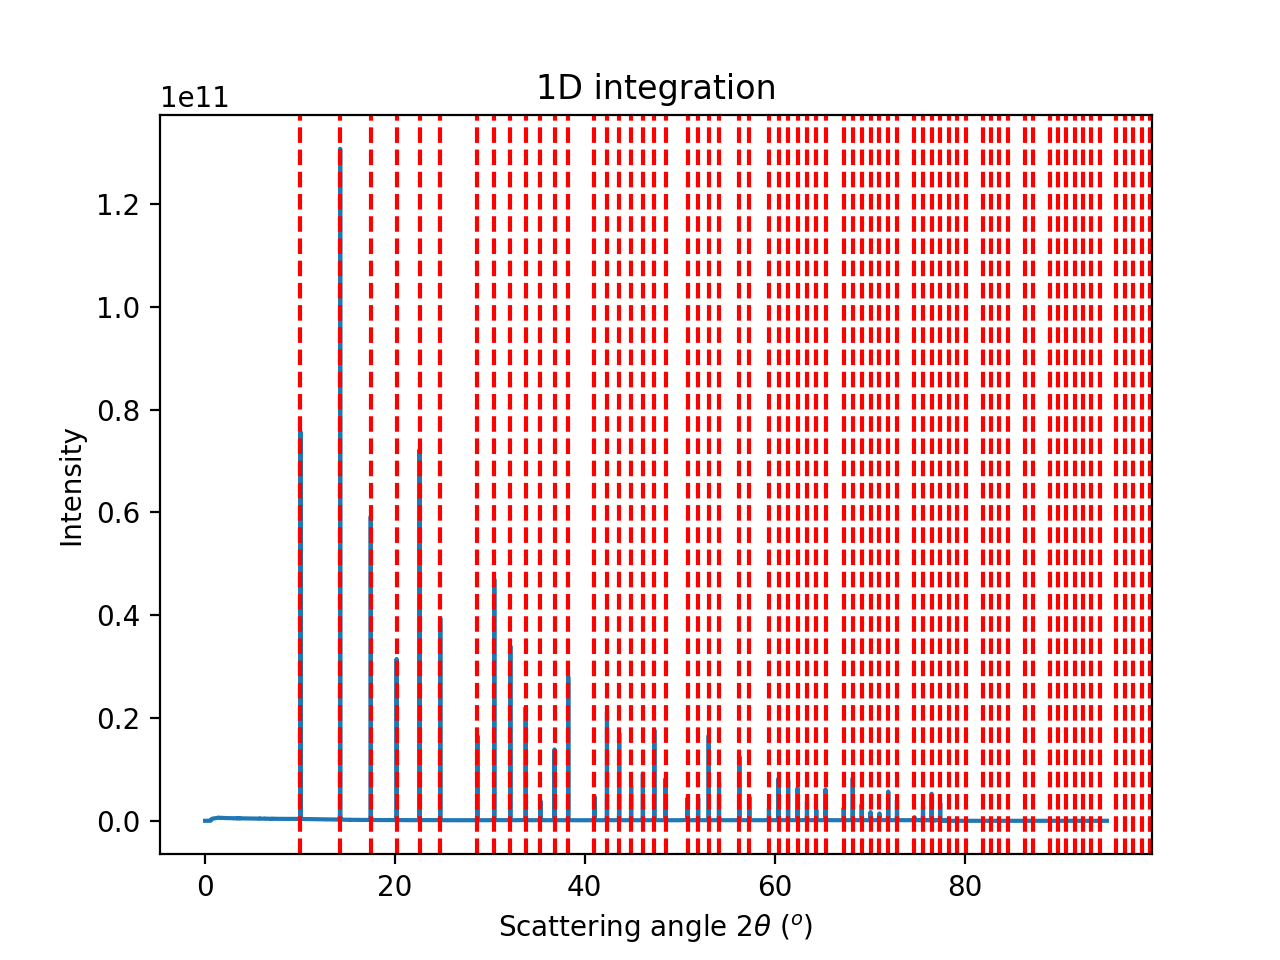

<IPython.core.display.Javascript object>


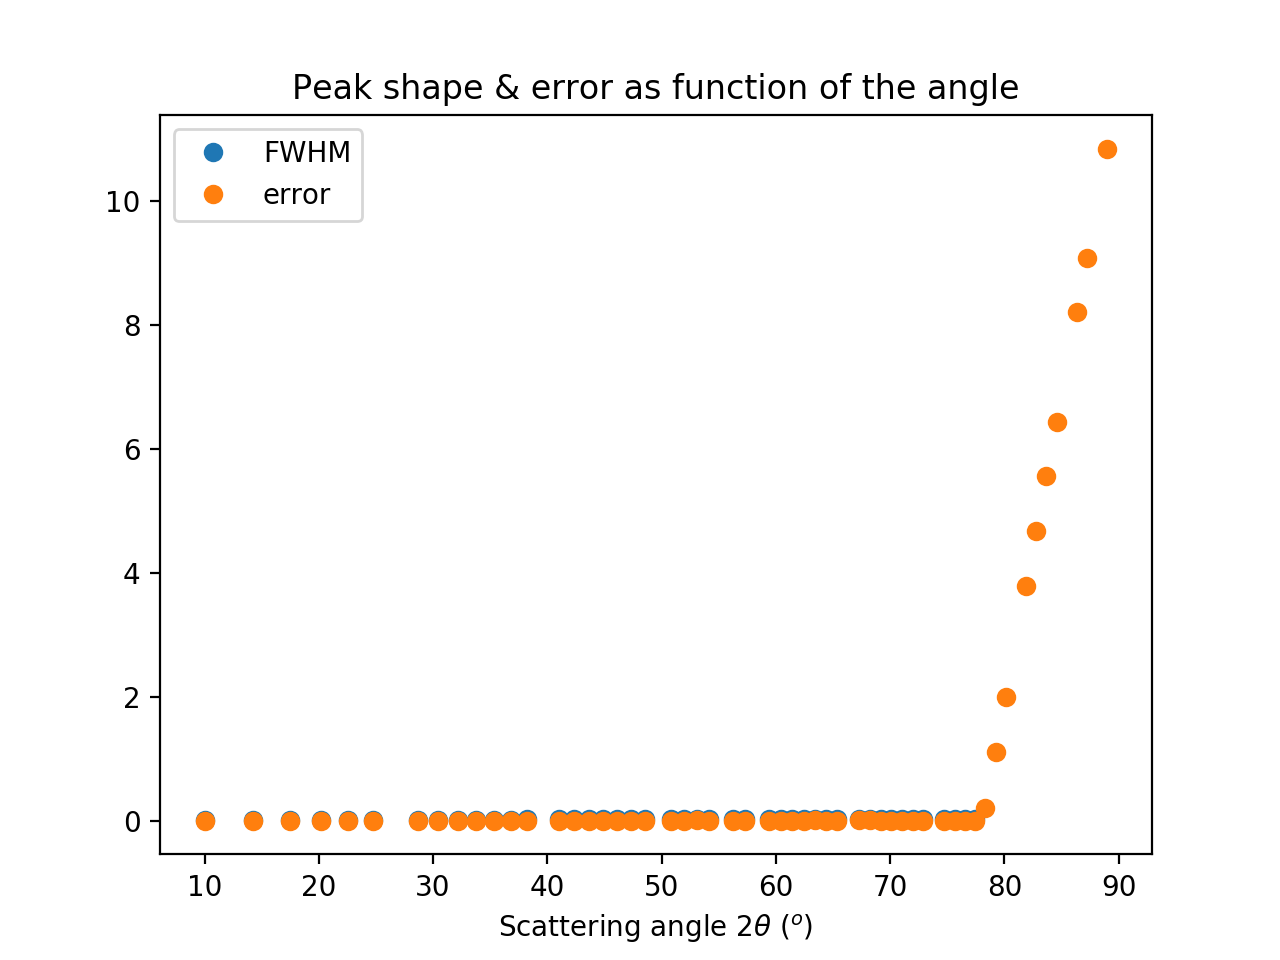

24026
64 54


In [35]:
add_module(ds_names[3],
           121,
           159,
           179)

2.31928596727e-07
Cost function before refinement: 2.31928596727e-07
[  7.20000000e-01   3.20000000e-02   4.00000000e-03   0.00000000e+00
  -6.00000556e+01   1.00000000e+00   1.70270825e+01]
     fun: 2.0856624751999954e-10
     jac: array([ -2.72031959e-07,   2.34632462e-08,  -3.13650477e-11,
         1.14575097e-09,  -9.14368789e-11,  -1.88744526e-07,
         5.83778581e-11,   0.00000000e+00])
 message: 'Optimization terminated successfully.'
    nfev: 19
     nit: 2
    njev: 2
  status: 0
 success: True
       x: array([  7.19996884e-01,   3.16531473e-02,   4.00000000e-03,
         0.00000000e+00,  -6.00000599e+01,   1.00000000e+00,
         1.70270825e+01])
Cost function after refinement: 2.0856624752e-10
GonioParam(dist=0.719996884236354, poni1=0.031653147292955666, poni2=0.0040000000000000001, rot1=0.0, offset=-60.000059921063432, scale=1.0, nrj=17.027082549190933)
maxdelta on: poni1 (1) 0.032 --> 0.031653147293
 Number of peaks found and used for refinement
864
Cost function b

<IPython.core.display.Javascript object>


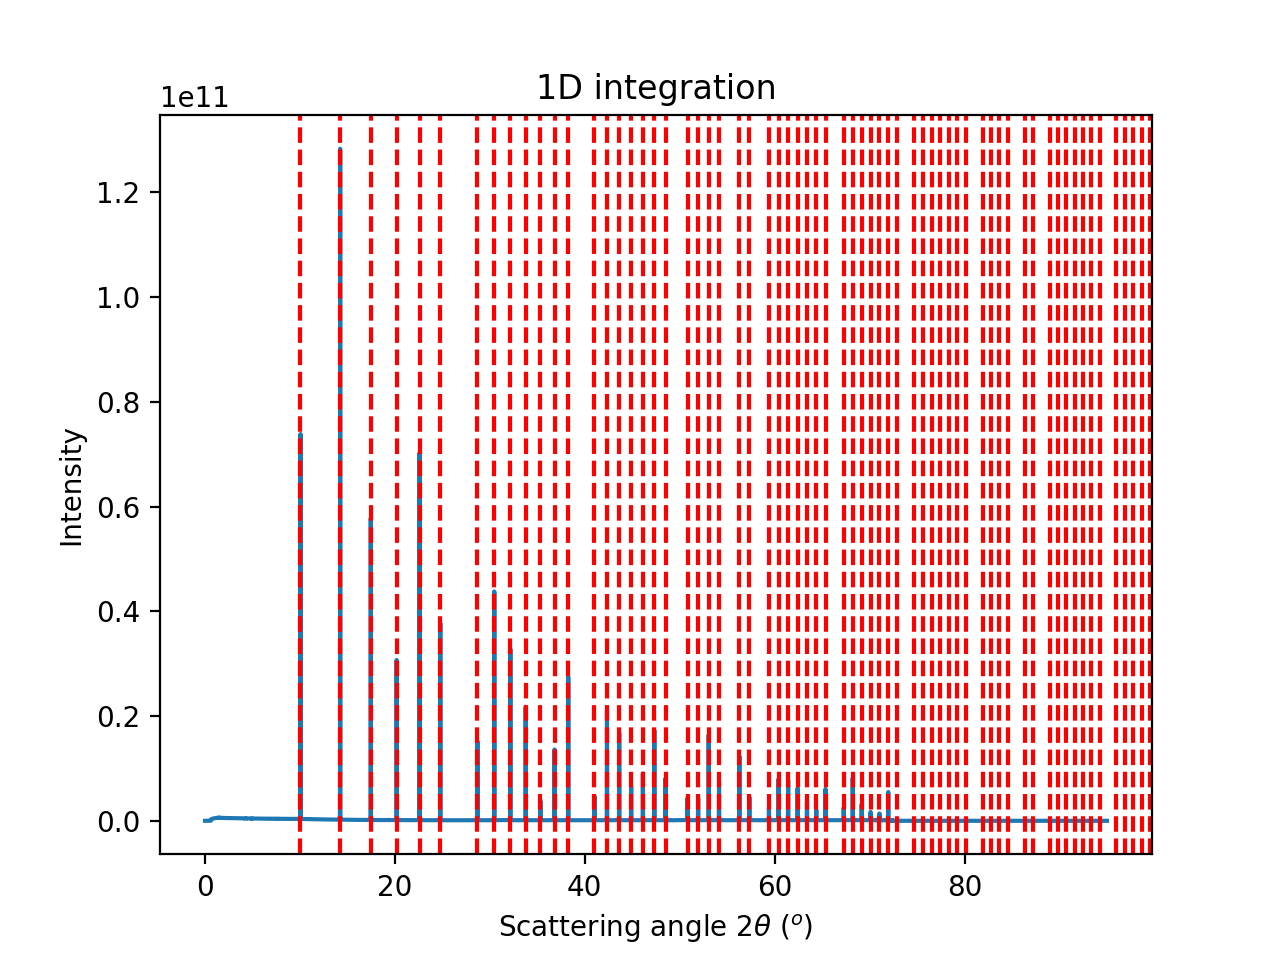

<IPython.core.display.Javascript object>


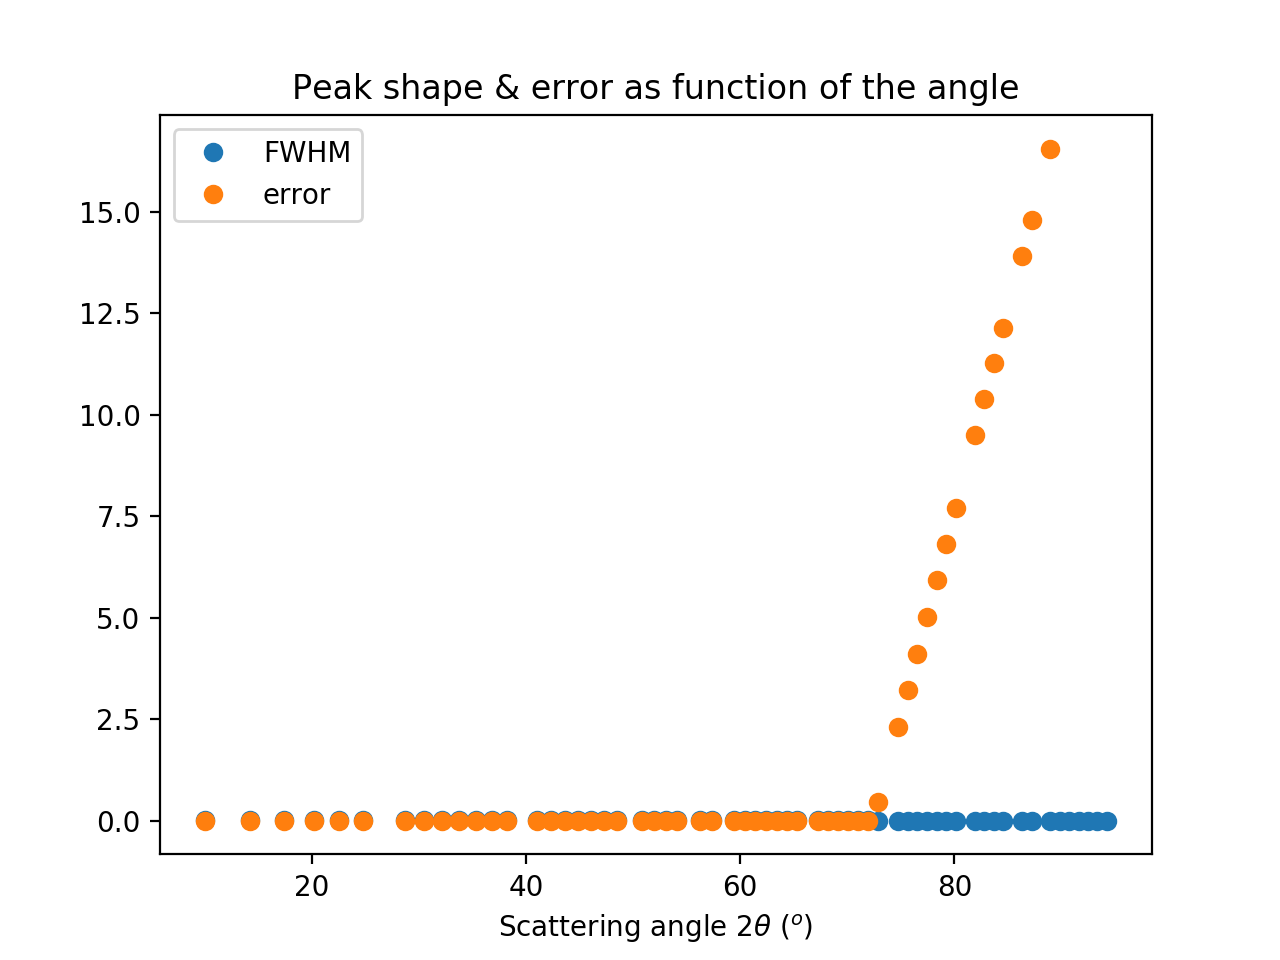

22258
56 54


In [36]:
add_module(ds_names[4],
           150,
           188,
           208)

1.49658553869e-06
Cost function before refinement: 1.49658553869e-06
[  7.20000000e-01   3.20000000e-02   4.00000000e-03   0.00000000e+00
  -5.43998333e+01   1.00000000e+00   1.70270825e+01]
     fun: 2.0171535150920134e-10
     jac: array([ -2.79014458e-07,   1.12723053e-07,   2.76456642e-09,
        -8.39426390e-10,   1.01678678e-09,  -1.46581687e-07,
        -5.97716569e-10,   0.00000000e+00])
 message: 'Optimization terminated successfully.'
    nfev: 19
     nit: 2
    njev: 2
  status: 0
 success: True
       x: array([  7.20008138e-01,   3.28813990e-02,   4.00000000e-03,
         0.00000000e+00,  -5.43998223e+01,   1.00000000e+00,
         1.70270825e+01])
Cost function after refinement: 2.01715351509e-10
GonioParam(dist=0.72000813780395123, poni1=0.032881399004814668, poni2=0.0040000000000000001, rot1=0.0, offset=-54.399822256631786, scale=1.0, nrj=17.027082549190933)
maxdelta on: poni1 (1) 0.032 --> 0.0328813990048
 Number of peaks found and used for refinement
754
Cost functi

<IPython.core.display.Javascript object>


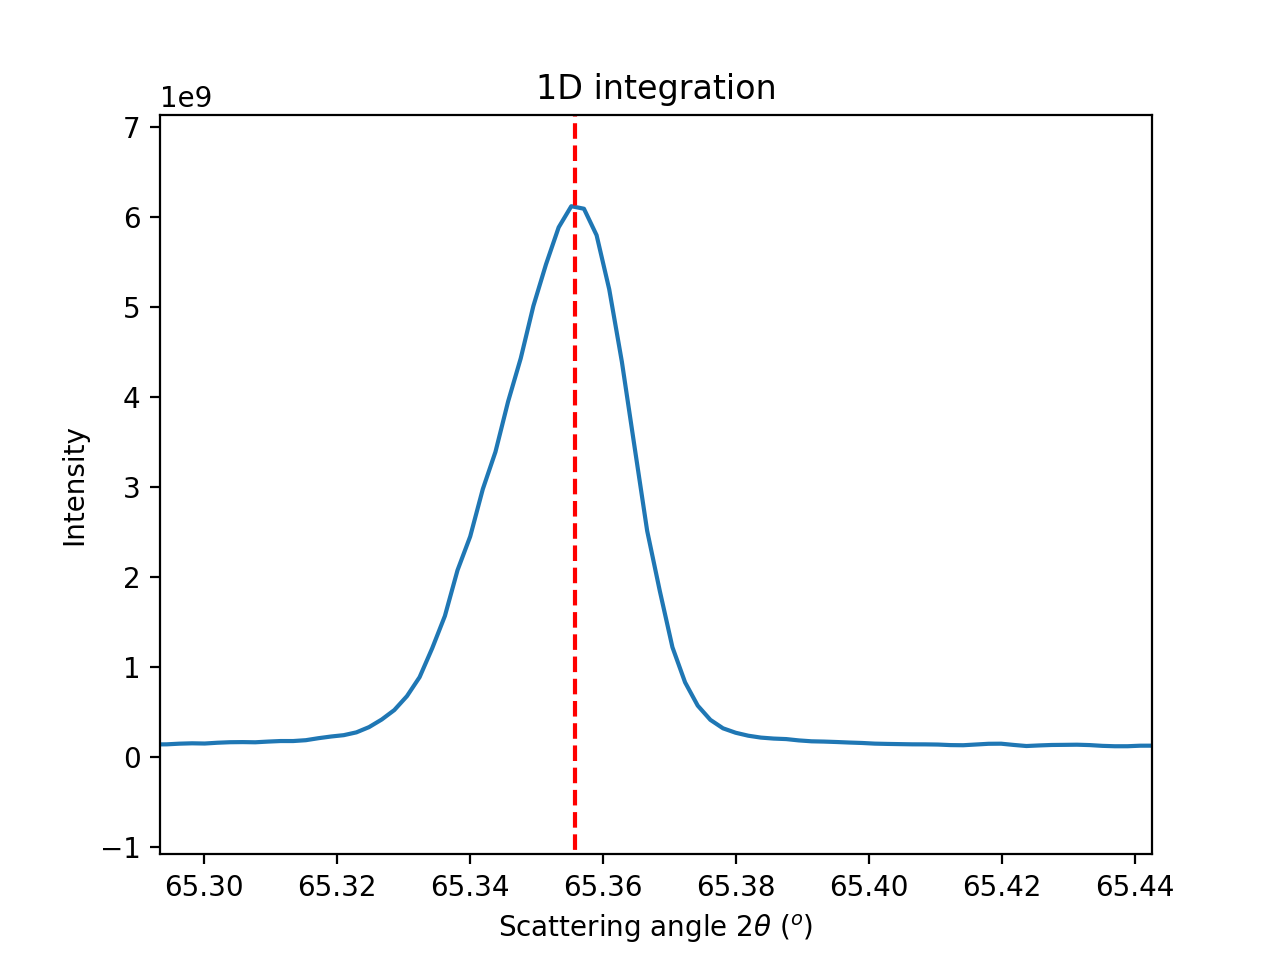

<IPython.core.display.Javascript object>


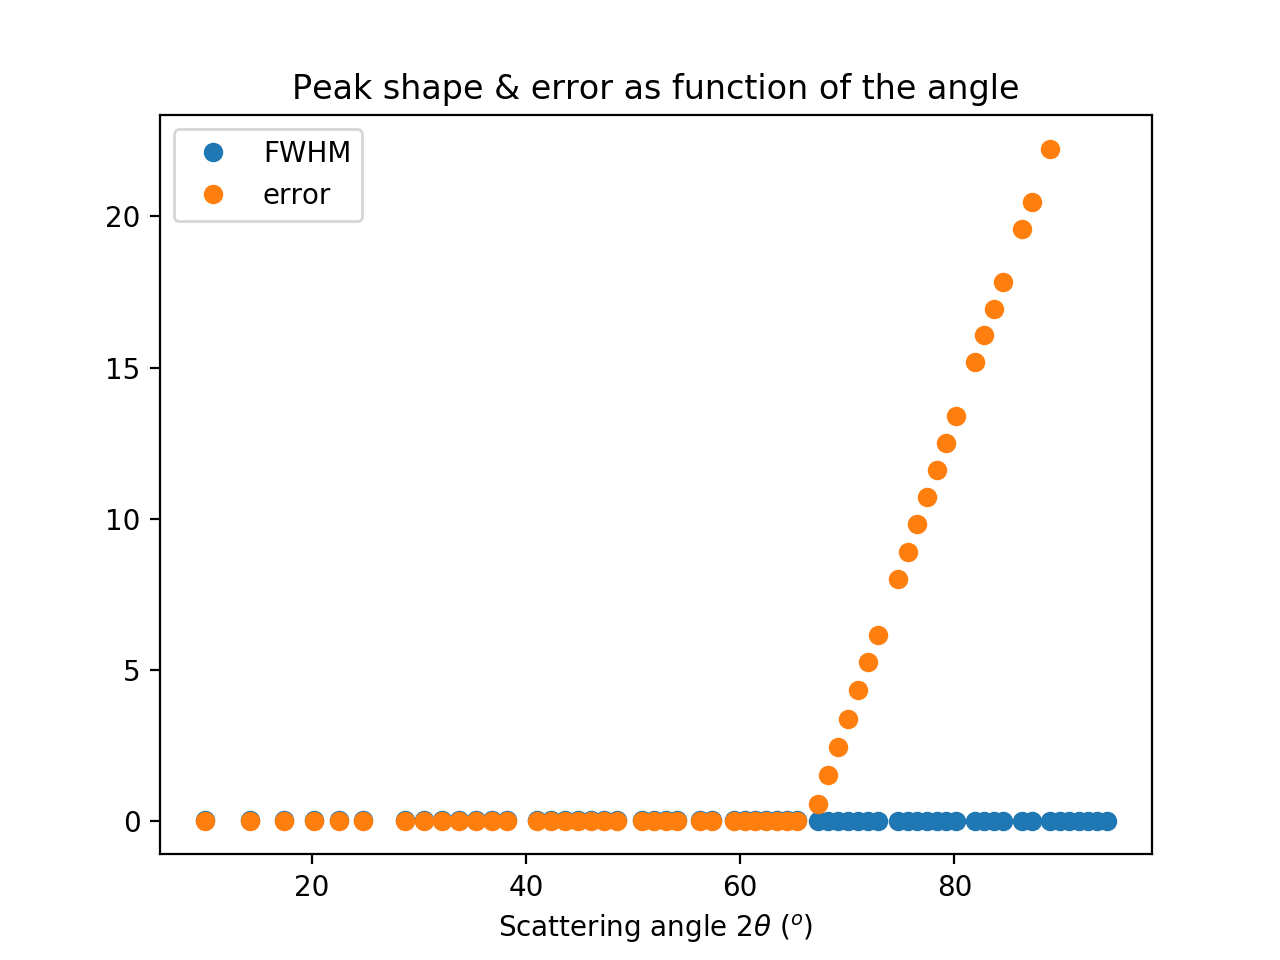

20560
54 54


In [37]:
add_module(ds_names[5],
           178,
           216,
           236)

7.4147637454e-08
Cost function before refinement: 7.4147637454e-08
[  7.20000000e-01   3.20000000e-02   4.00000000e-03   0.00000000e+00
  -4.85998889e+01   1.00000000e+00   1.70270825e+01]
     fun: 5.6513401976066356e-11
     jac: array([ -2.81311437e-07,   1.90457697e-08,  -2.47022619e-10,
         1.33814411e-09,  -1.23389936e-10,  -2.00557892e-07,
         7.73080818e-11,   0.00000000e+00])
 message: 'Optimization terminated successfully.'
    nfev: 19
     nit: 2
    njev: 2
  status: 0
 success: True
       x: array([  7.19998572e-01,   3.18038587e-02,   4.00000000e-03,
         0.00000000e+00,  -4.85998914e+01,   1.00000000e+00,
         1.70270825e+01])
Cost function after refinement: 5.65134019761e-11
GonioParam(dist=0.71999857175267501, poni1=0.031803858748058605, poni2=0.0040000000000000001, rot1=0.0, offset=-48.599891358709684, scale=1.0, nrj=17.027082549190933)
maxdelta on: poni1 (1) 0.032 --> 0.0318038587481
 Number of peaks found and used for refinement
626
Cost function

<IPython.core.display.Javascript object>


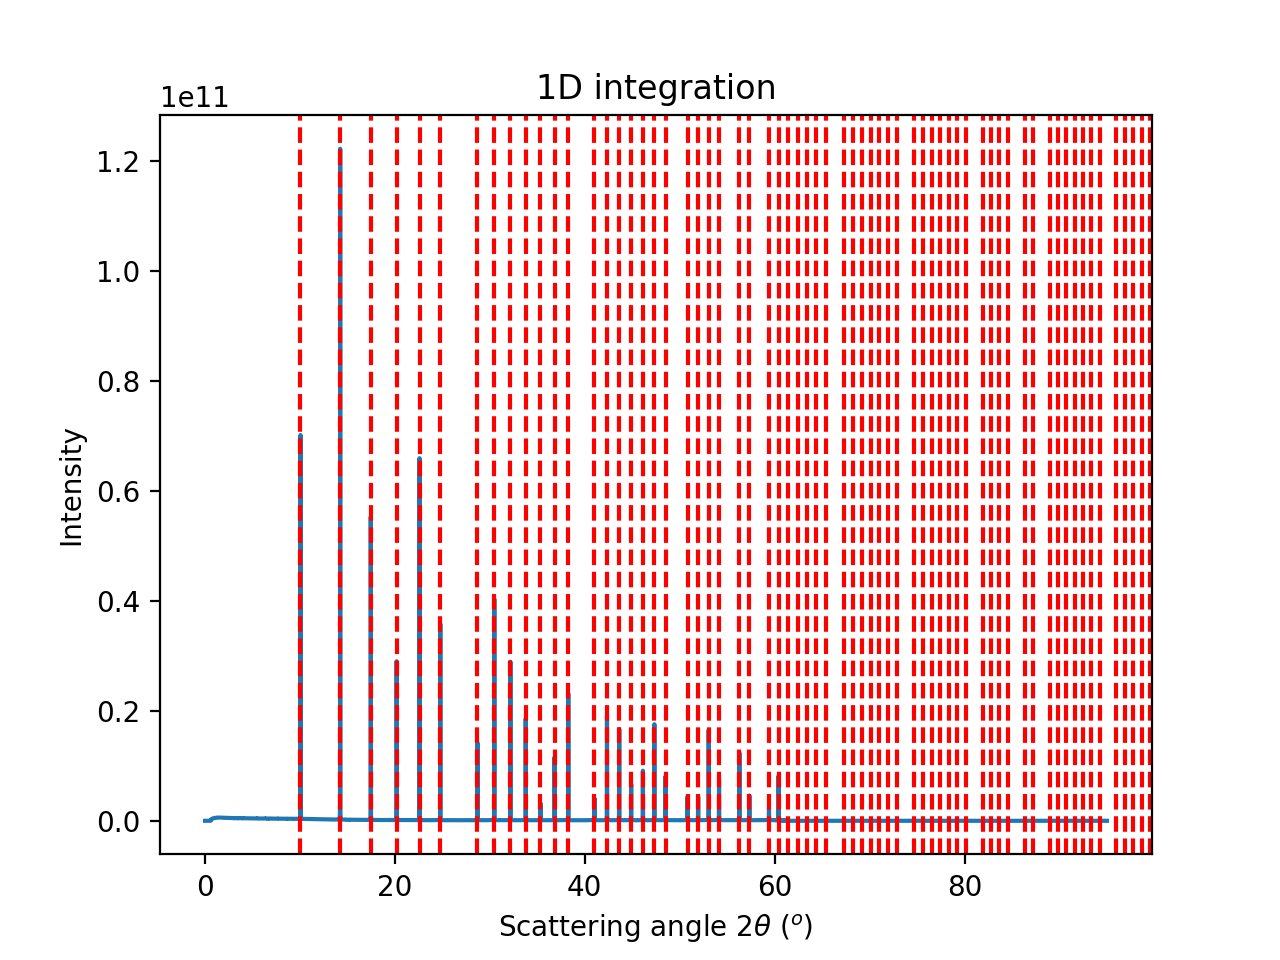

<IPython.core.display.Javascript object>


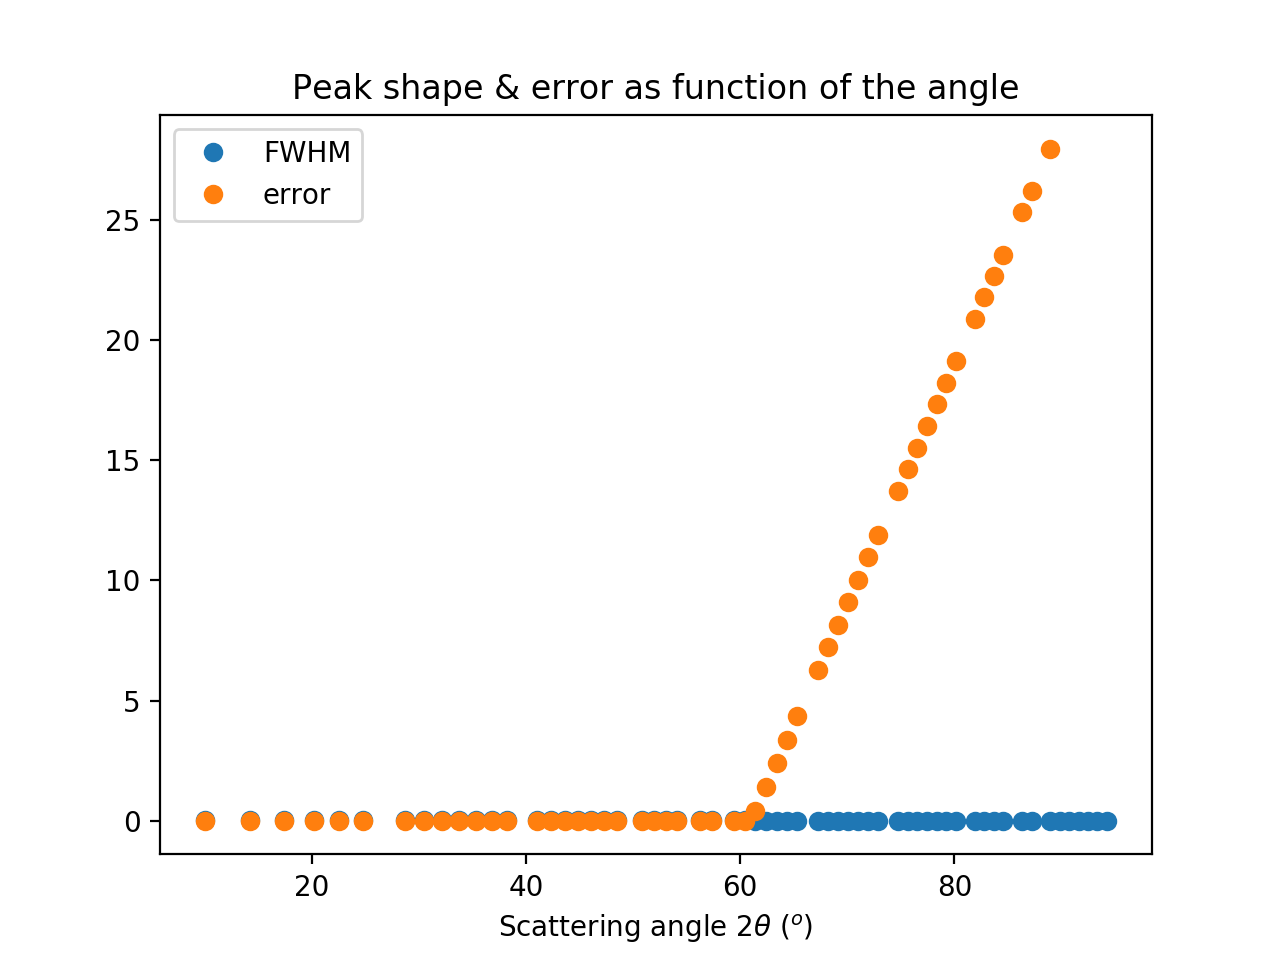

18647
54 54


In [38]:
add_module(ds_names[6],
           207,
           245,
           266)

4.37748174147e-06
Cost function before refinement: 4.37748174147e-06
[  7.20000000e-01   3.20000000e-02   4.00000000e-03   0.00000000e+00
  -4.27998889e+01   1.00000000e+00   1.70270825e+01]
     fun: 9.1090582434863962e-11
     jac: array([ -3.53771074e-07,   3.50167703e-09,  -7.17406458e-10,
         1.96667227e-09,  -3.65232464e-10,  -2.61708398e-07,
         2.20481224e-10,   0.00000000e+00])
 message: 'Optimization terminated successfully.'
    nfev: 19
     nit: 2
    njev: 2
  status: 0
 success: True
       x: array([  7.19986034e-01,   3.04925065e-02,   4.00000000e-03,
         0.00000000e+00,  -4.27999078e+01,   1.00000000e+00,
         1.70270825e+01])
Cost function after refinement: 9.10905824349e-11
GonioParam(dist=0.7199860338026991, poni1=0.030492506521307684, poni2=0.0040000000000000001, rot1=0.0, offset=-42.799907844479307, scale=1.0, nrj=17.027082549190933)
maxdelta on: poni1 (1) 0.032 --> 0.0304925065213
 Number of peaks found and used for refinement
543
Cost functio

<IPython.core.display.Javascript object>


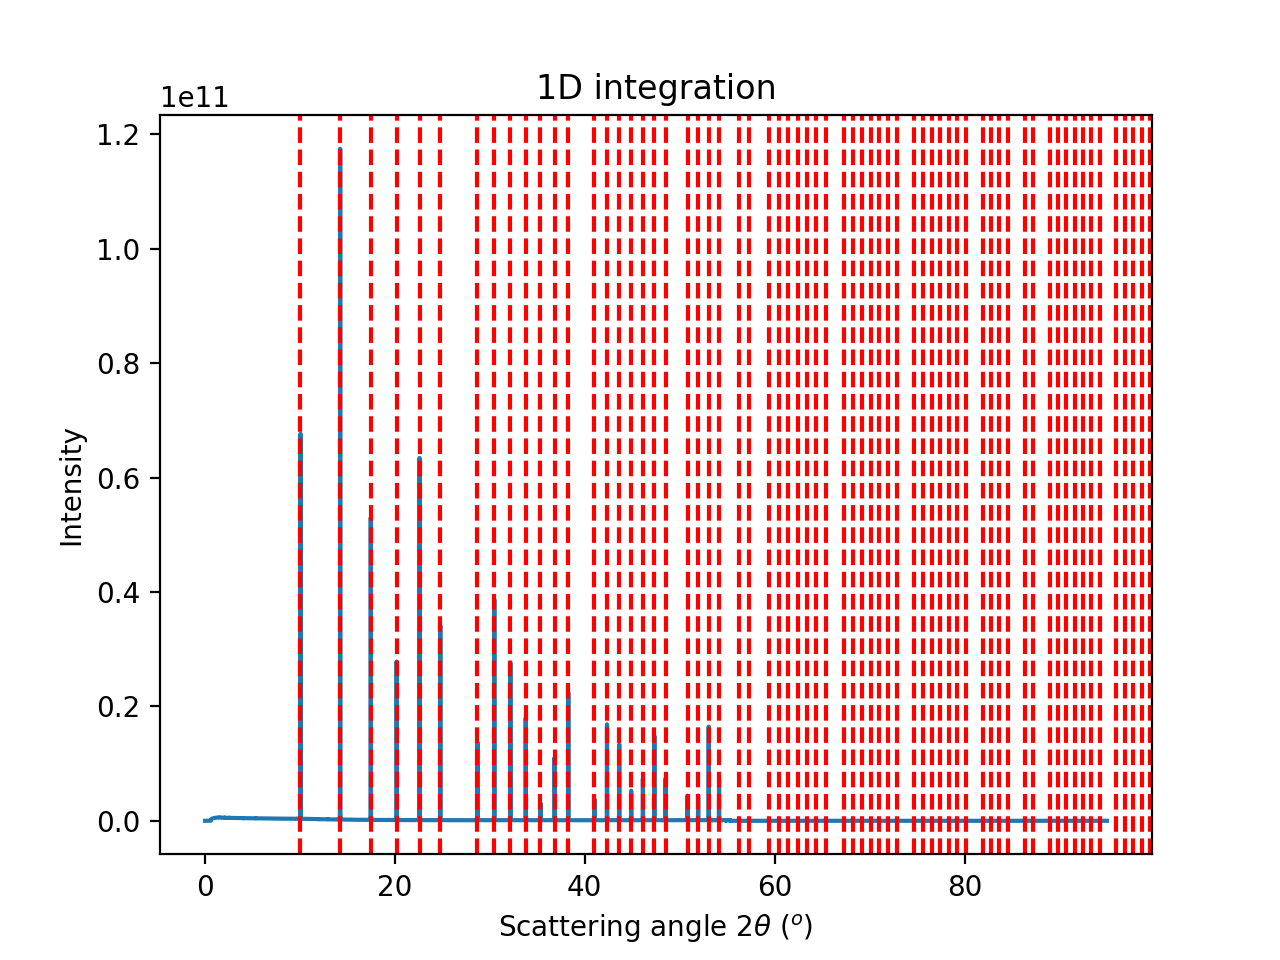

<IPython.core.display.Javascript object>


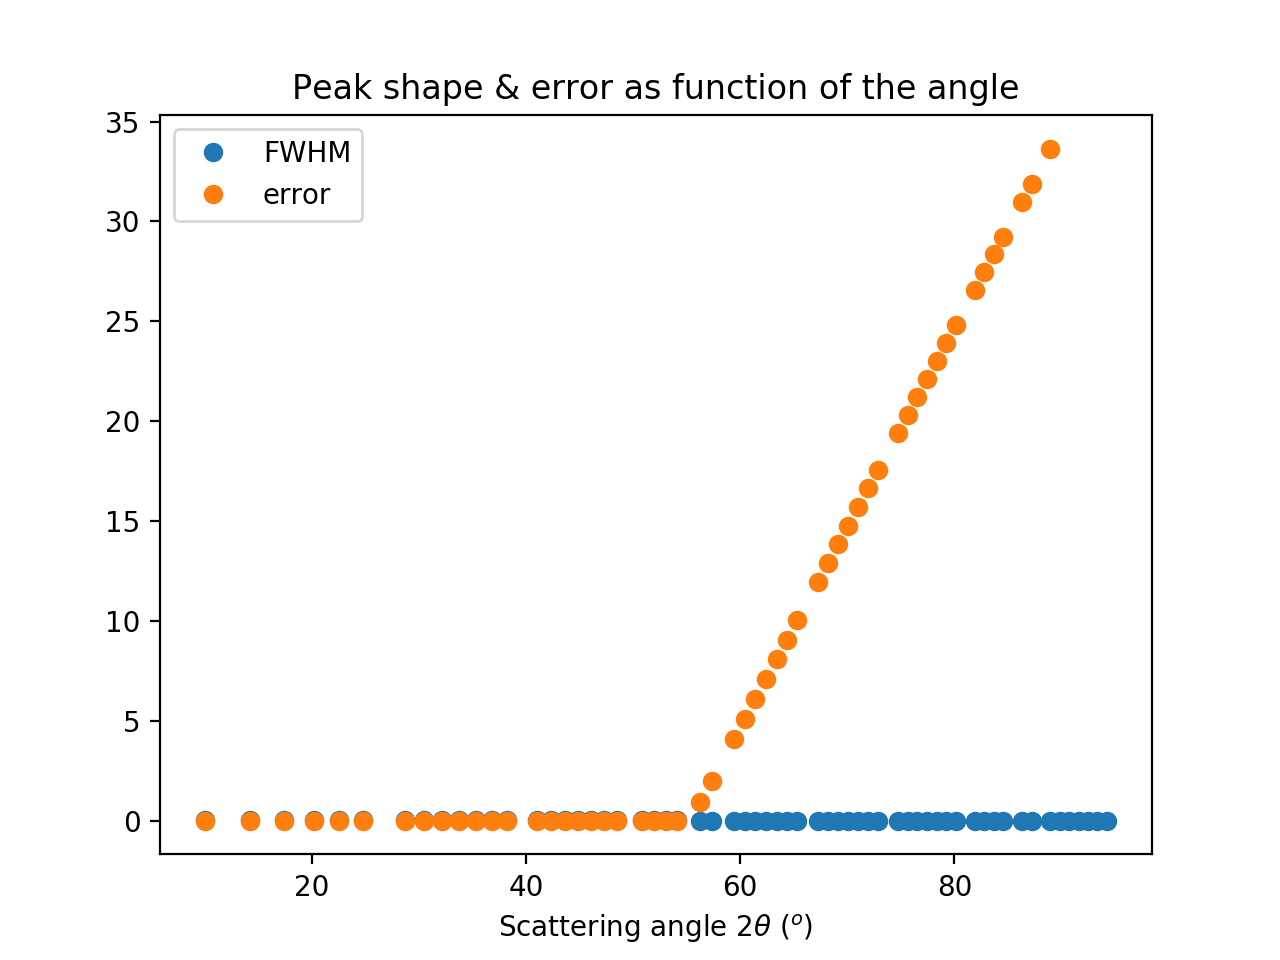

16809
45 54


In [39]:
add_module(ds_names[7],
           236,
           273,
           293)

9.7340448025e-08
Cost function before refinement: 9.7340448025e-08
[  7.20000000e-01   3.20000000e-02   4.00000000e-03   0.00000000e+00
  -3.72000000e+01   1.00000000e+00   1.70270825e+01]
     fun: 1.3838347147363678e-10
     jac: array([ -5.98673543e-07,   2.23605236e-08,  -1.03159942e-10,
         2.50403027e-09,  -2.11195058e-10,  -4.33428498e-07,
         1.29258940e-10,   0.00000000e+00])
 message: 'Optimization terminated successfully.'
    nfev: 19
     nit: 2
    njev: 2
  status: 0
 success: True
       x: array([  7.19998053e-01,   3.17753501e-02,   4.00000000e-03,
         0.00000000e+00,  -3.72000028e+01,   1.00000000e+00,
         1.70270825e+01])
Cost function after refinement: 1.38383471474e-10
GonioParam(dist=0.71999805332326128, poni1=0.03177535006475983, poni2=0.0040000000000000001, rot1=0.0, offset=-37.20000282727144, scale=1.0, nrj=17.027082549190933)
maxdelta on: poni1 (1) 0.032 --> 0.0317753500648
 Number of peaks found and used for refinement
454
Cost function b

<IPython.core.display.Javascript object>


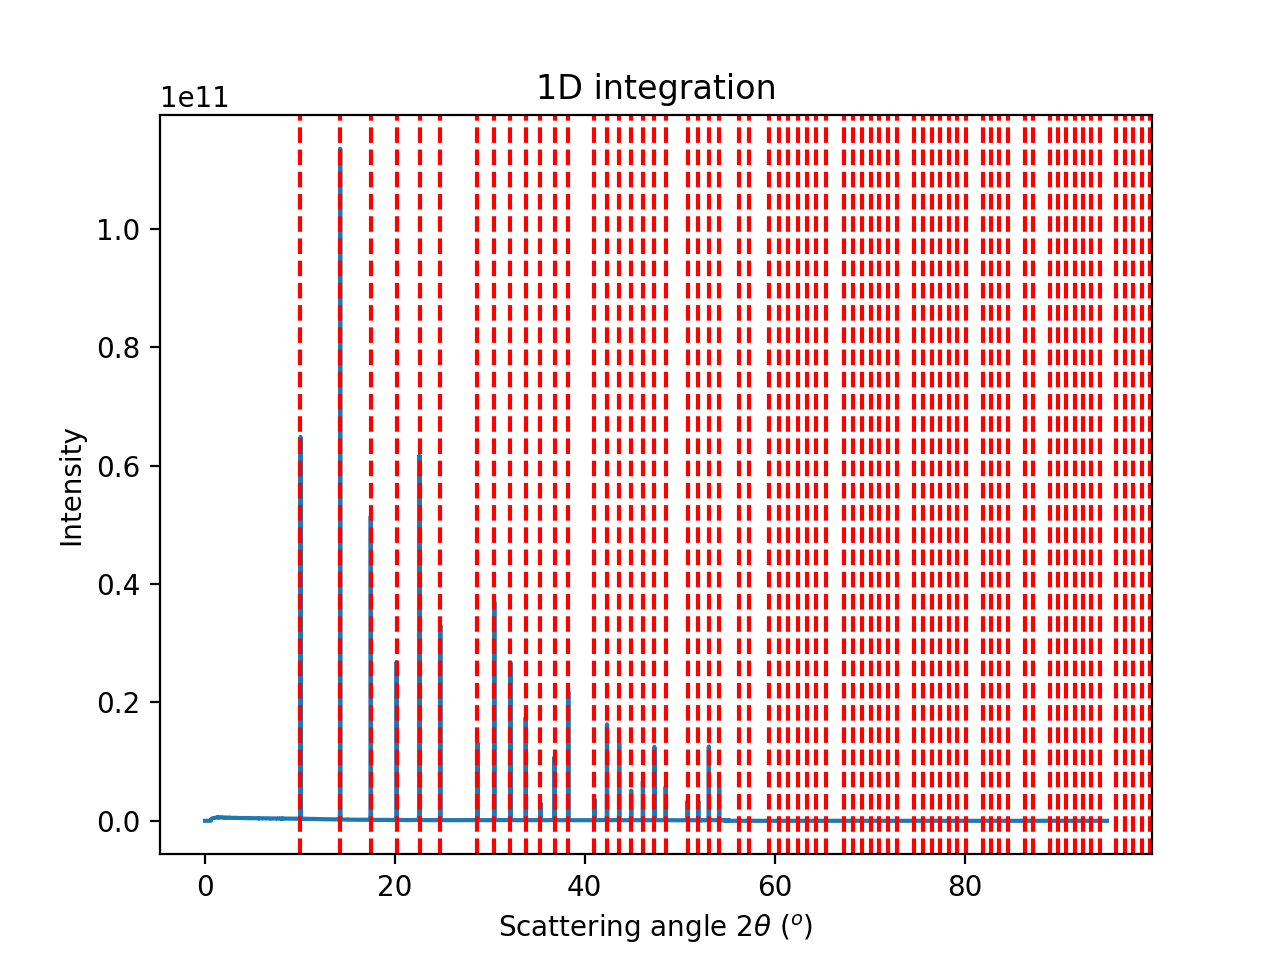

<IPython.core.display.Javascript object>


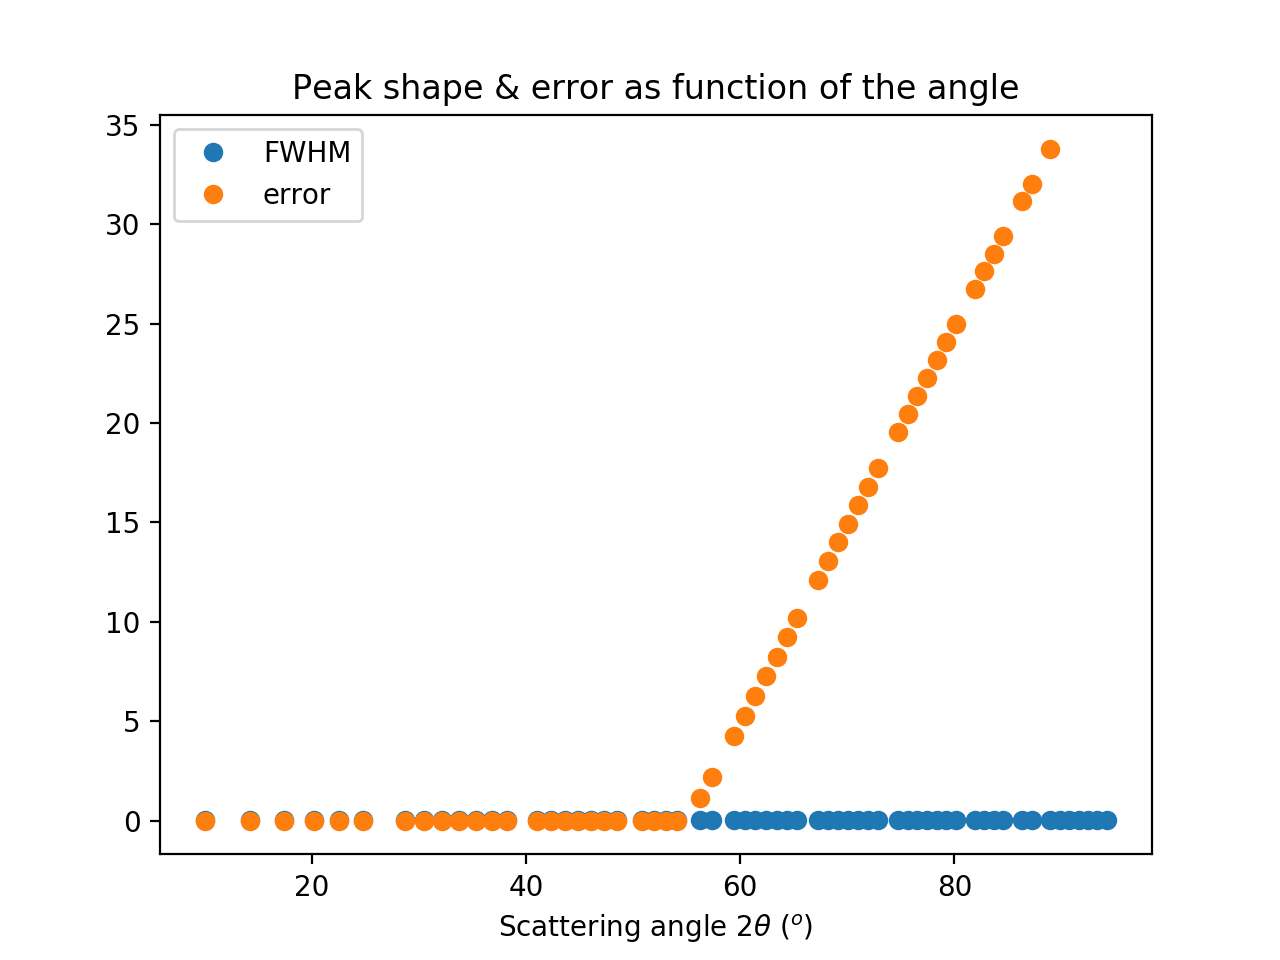

16876
45 54


In [40]:
add_module(ds_names[8],
           264,
           302,
           322)

In [41]:
len(goniometers)

9

In [42]:
# print all the parameters to be able to compare them visually
goniometers["data_12"] = goniometers["data_11"]
for name in ds_names:
    print(name, *["%8.4e"%i for i in goniometers[name].param])

data_02 7.2310e-01 3.2054e-02 3.9849e-03 1.0948e-05 -8.2800e+01 9.9942e-01 1.7027e+01
data_03 7.2068e-01 3.3678e-02 4.0580e-03 -4.4486e-05 -7.7200e+01 9.9897e-01 1.7027e+01
data_04 7.2069e-01 3.4825e-02 4.0432e-03 -3.3769e-05 -7.1600e+01 9.9898e-01 1.7027e+01
data_05 7.2048e-01 3.3410e-02 3.9779e-03 1.5910e-05 -6.5800e+01 9.9900e-01 1.7027e+01
data_07 7.2065e-01 3.2237e-02 3.9757e-03 1.7542e-05 -6.0000e+01 9.9901e-01 1.7027e+01
data_08 7.2053e-01 3.3395e-02 3.9730e-03 1.9484e-05 -5.4400e+01 9.9903e-01 1.7027e+01
data_09 7.2061e-01 3.2247e-02 3.9689e-03 2.2376e-05 -4.8600e+01 9.9904e-01 1.7027e+01
data_10 7.2071e-01 3.0863e-02 3.9652e-03 2.5070e-05 -4.2800e+01 9.9905e-01 1.7027e+01
data_11 7.2081e-01 3.2082e-02 3.9596e-03 2.9091e-05 -3.7200e+01 9.9906e-01 1.7027e+01
data_12 7.2081e-01 3.2082e-02 3.9596e-03 2.9091e-05 -3.7200e+01 9.9906e-01 1.7027e+01


## Use the negative part of the spectum ...

Until now, we used only the data where 2th >0 
For the last modules, this thows away half of the data.

We setup here a way to assign the peaks for the negative part of the spectrum.

In [43]:
def complete_gonio(module_id=None, name=None):
    "Scan missing frames for un-indexed peaks"
    if name is None:
        name = ds_names[module_id]
    gonioref = goniometers[name]
    ds = data[name]
    print("Number of peaks previously found:",
           sum([len(sg.geometry_refinement.data) for sg in gonioref.single_geometries.values()]))

    tths = LaB6.get_2th()

    for i in range(ds.shape[0]):
        frame_name = "%s_%04i"%(name, i)
        if frame_name in gonioref.single_geometries:
                continue
        peak = peak_picking(name, i)
        ai=gonioref.get_ai(get_position(i))
        tth = ai.array_from_unit(unit="2th_rad", scale=False)
        tth_low = tth[20]
        tth_hi = tth[-20]
        ttmin, ttmax = min(tth_low, tth_hi), max(tth_low, tth_hi)
        valid_peaks = numpy.logical_and(ttmin<=tths, tths<ttmax)
        cnt = valid_peaks.sum()
        if (len(peak) ==  cnt) and cnt>0:    
            cp = ControlPoints(calibrant=LaB6, wavelength=wl)
            #revert the order of assignment if needed !!
            if tth_hi < tth_low:
                peak = peak[-1::-1]
            for p, r in zip(peak, numpy.where(valid_peaks)[0]):
                cp.append([p], ring=r)
            img = ds[i].reshape((-1,1))
            sg = gonioref.new_geometry(frame_name, 
                                        image=img, 
                                        metadata=i, 
                                        control_points=cp, 
                                        calibrant=LaB6)
            sg.geometry_refinement.data = numpy.array(cp.getList())
            #print(frame_name, len(sg.geometry_refinement.data))

    print("Number of peaks found after re-scan:",
            sum([len(sg.geometry_refinement.data) for sg in gonioref.single_geometries.values()]))
    return gonioref

In [44]:
gonio8 = complete_gonio(module_id=8)
gonio8.refine2()

Number of peaks previously found: 454
Number of peaks found after re-scan: 1006
Cost function before refinement: 4.70706125439e-09
[  7.20810790e-01   3.20817605e-02   3.95963325e-03   2.90908690e-05
  -3.71999988e+01   9.99058845e-01   1.70270825e+01]
     fun: 9.8027376826043753e-10
     jac: array([ -8.29338917e-07,   1.79786978e-08,  -2.22576465e-07,
         1.63791395e-07,  -1.37361011e-10,  -3.00380388e-08,
         3.83178298e-08,   0.00000000e+00])
 message: 'Optimization terminated successfully.'
    nfev: 37
     nit: 4
    njev: 4
  status: 0
 success: True
       x: array([  7.20813440e-01,   3.20849228e-02,   3.96153953e-03,
         2.77060750e-05,  -3.71999988e+01,   9.98991349e-01,
         1.70270825e+01])
Cost function after refinement: 9.8027376826e-10
GonioParam(dist=0.72081344007556147, poni1=0.032084922776918608, poni2=0.0039615395273725129, rot1=2.770607503862905e-05, offset=-37.199998785744533, scale=0.99899134871913886, nrj=17.027082549190933)
maxdelta on: sca

array([  7.20813440e-01,   3.20849228e-02,   3.96153953e-03,
         2.77060750e-05,  -3.71999988e+01,   9.98991349e-01,
         1.70270825e+01])

In [45]:
gonio7 = complete_gonio(module_id=7)

Number of peaks previously found: 543
Number of peaks found after re-scan: 1004


In [46]:
gonio7.refine2()

Cost function before refinement: 2.04975065466e-09
[  7.20707163e-01   3.08633971e-02   3.96520588e-03   2.50699030e-05
  -4.27999030e+01   9.99050597e-01   1.70270825e+01]
     fun: 6.982178014396509e-10
     jac: array([ -6.61610503e-07,   1.82061135e-08,  -2.31096076e-07,
         1.69227578e-07,  -1.05927128e-10,  -2.98934004e-08,
         2.67495021e-08,   0.00000000e+00])
 message: 'Optimization terminated successfully.'
    nfev: 37
     nit: 4
    njev: 4
  status: 0
 success: True
       x: array([  7.20709219e-01,   3.08662496e-02,   3.96669042e-03,
         2.39916666e-05,  -4.27999029e+01,   9.99006679e-01,
         1.70270825e+01])
Cost function after refinement: 6.9821780144e-10
GonioParam(dist=0.72070921907349117, poni1=0.030866249621701404, poni2=0.0039666904208374675, rot1=2.3991666571782472e-05, offset=-42.799902936952186, scale=0.99900667875716065, nrj=17.027082549190933)
maxdelta on: scale (5) 0.999050596847 --> 0.999006678757


array([  7.20709219e-01,   3.08662496e-02,   3.96669042e-03,
         2.39916666e-05,  -4.27999029e+01,   9.99006679e-01,
         1.70270825e+01])

In [47]:
gonio6 = complete_gonio(module_id=6)
gonio6.refine2()

Number of peaks previously found: 626
Number of peaks found after re-scan: 990
Cost function before refinement: 9.05404856656e-10
[  7.20609298e-01   3.22472627e-02   3.96893520e-03   2.23757106e-05
  -4.85998857e+01   9.99040899e-01   1.70270825e+01]
     fun: 6.0937286422463489e-10
     jac: array([ -8.02155920e-07,   3.63691515e-08,  -2.33166253e-07,
         1.71261021e-07,   1.53140861e-10,  -6.90587253e-08,
         3.30203031e-08,   0.00000000e+00])
 message: 'Optimization terminated successfully.'
    nfev: 37
     nit: 4
    njev: 4
  status: 0
 success: True
       x: array([  7.20611756e-01,   3.22490408e-02,   3.97006720e-03,
         2.15500507e-05,  -4.85998856e+01,   9.99018033e-01,
         1.70270825e+01])
Cost function after refinement: 6.09372864225e-10
GonioParam(dist=0.72061175643914144, poni1=0.032249040759327559, poni2=0.0039700672022823114, rot1=2.1550050733043843e-05, offset=-48.599885636781195, scale=0.99901803336191386, nrj=17.027082549190933)
maxdelta on: sc

array([  7.20611756e-01,   3.22490408e-02,   3.97006720e-03,
         2.15500507e-05,  -4.85998856e+01,   9.99018033e-01,
         1.70270825e+01])

In [48]:
gonio5 = complete_gonio(module_id=5)
gonio5.refine2()

Number of peaks previously found: 754
Number of peaks found after re-scan: 1038
Cost function before refinement: 5.32231244727e-10
[  7.20528271e-01   3.33948197e-02   3.97295090e-03   1.94838596e-05
  -5.43998157e+01   9.99025942e-01   1.70270825e+01]
     fun: 5.2478142976150044e-10
     jac: array([ -6.54781369e-07,   1.29256630e-07,  -1.62656541e-07,
         1.19840950e-07,   1.28911966e-09,  -2.77499652e-07,
         2.46511989e-08,   0.00000000e+00])
 message: 'Optimization terminated successfully.'
    nfev: 37
     nit: 4
    njev: 4
  status: 0
 success: True
       x: array([  7.20530687e-01,   3.33953448e-02,   3.97363667e-03,
         1.89799990e-05,  -5.43998157e+01,   9.99021890e-01,
         1.70270825e+01])
Cost function after refinement: 5.24781429762e-10
GonioParam(dist=0.72053068653374164, poni1=0.033395344810677706, poni2=0.0039736366657854355, rot1=1.8979998986411344e-05, offset=-54.399815657354473, scale=0.99902189022863797, nrj=17.027082549190933)
maxdelta on: s

array([  7.20530687e-01,   3.33953448e-02,   3.97363667e-03,
         1.89799990e-05,  -5.43998157e+01,   9.99021890e-01,
         1.70270825e+01])

In [49]:
gonio4 = complete_gonio(module_id=4)
gonio4.refine2()

Number of peaks previously found: 864
Number of peaks found after re-scan: 1081
Cost function before refinement: 4.52298158065e-10
[  7.20645314e-01   3.22371238e-02   3.97565133e-03   1.75424155e-05
  -6.00000524e+01   9.99011856e-01   1.70270825e+01]
     fun: 4.3299683203028782e-10
     jac: array([ -3.23619143e-07,  -1.33810126e-08,  -8.07893403e-08,
         5.95277891e-08,  -4.92710775e-10,   3.16598865e-08,
         5.83323419e-08,   0.00000000e+00])
 message: 'Optimization terminated successfully.'
    nfev: 37
     nit: 4
    njev: 4
  status: 0
 success: True
       x: array([  7.20646423e-01,   3.22359951e-02,   3.97581932e-03,
         1.74168753e-05,  -6.00000525e+01,   9.99019702e-01,
         1.70270825e+01])
Cost function after refinement: 4.3299683203e-10
GonioParam(dist=0.7206464234341815, poni1=0.032235995133433754, poni2=0.0039758193176266145, rot1=1.7416875286579755e-05, offset=-60.000052450675177, scale=0.99901970217961722, nrj=17.027082549190933)
maxdelta on: sca

array([  7.20646423e-01,   3.22359951e-02,   3.97581932e-03,
         1.74168753e-05,  -6.00000525e+01,   9.99019702e-01,
         1.70270825e+01])

In [50]:
gonio3 = complete_gonio(module_id=3)
gonio3.refine2()

Number of peaks previously found: 978
Number of peaks found after re-scan: 1156
Cost function before refinement: 7.0532386877e-10
[  7.20482931e-01   3.34099564e-02   3.97791142e-03   1.59099880e-05
  -6.57999266e+01   9.98999110e-01   1.70270825e+01]
     fun: 6.3168196012964885e-10
     jac: array([ -4.99814708e-07,  -1.63155748e-08,   9.67096626e-09,
        -4.95315009e-09,  -5.75364555e-10,   3.90058487e-08,
         1.04654441e-07,   0.00000000e+00])
 message: 'Optimization terminated successfully.'
    nfev: 37
     nit: 4
    njev: 4
  status: 0
 success: True
       x: array([  7.20484799e-01,   3.34074959e-02,   3.97770054e-03,
         1.60543912e-05,  -6.57999266e+01,   9.99015617e-01,
         1.70270825e+01])
Cost function after refinement: 6.3168196013e-10
GonioParam(dist=0.72048479912607111, poni1=0.033407495931292989, poni2=0.0039777005422494648, rot1=1.6054391208637231e-05, offset=-65.799926589223574, scale=0.99901561714640574, nrj=17.027082549190933)
maxdelta on: sca

array([  7.20484799e-01,   3.34074959e-02,   3.97770054e-03,
         1.60543912e-05,  -6.57999266e+01,   9.99015617e-01,
         1.70270825e+01])

In [51]:
gonio2 = complete_gonio(module_id=2)
gonio2.refine2()

Number of peaks previously found: 1093
Number of peaks found after re-scan: 1229
Cost function before refinement: 8.30653358636e-10
[  7.20686437e-01   3.48247495e-02   4.04316666e-03  -3.37686772e-05
  -7.15999088e+01   9.98982863e-01   1.70270825e+01]
     fun: 7.7718910103728708e-10
     jac: array([  9.15257278e-08,  -1.05189468e-09,   5.61627546e-08,
        -4.08345480e-08,  -4.25668376e-10,   2.85157377e-09,
         1.17395008e-07,   0.00000000e+00])
 message: 'Optimization terminated successfully.'
    nfev: 37
     nit: 4
    njev: 4
  status: 0
 success: True
       x: array([  7.20686041e-01,   3.48226304e-02,   4.04289725e-03,
        -3.35729680e-05,  -7.15999088e+01,   9.98998235e-01,
         1.70270825e+01])
Cost function after refinement: 7.77189101037e-10
GonioParam(dist=0.72068604128736646, poni1=0.0348226304357366, poni2=0.004042897251336869, rot1=-3.3572967986179517e-05, offset=-71.599908838210922, scale=0.99899823499926654, nrj=17.027082549190933)
maxdelta on: sc

array([  7.20686041e-01,   3.48226304e-02,   4.04289725e-03,
        -3.35729680e-05,  -7.15999088e+01,   9.98998235e-01,
         1.70270825e+01])

In [52]:
gonio1 = complete_gonio(module_id=1)
gonio1.refine2()


Number of peaks previously found: 1183
Number of peaks found after re-scan: 1285
Cost function before refinement: 9.82265840537e-10
[  7.20682081e-01   3.36782425e-02   4.05801126e-03  -4.44860018e-05
  -7.71999788e+01   9.98967223e-01   1.70270825e+01]
     fun: 9.6838038223816251e-10
     jac: array([  1.05204414e-07,  -1.40910812e-09,  -2.64455137e-09,
         1.49411766e-09,  -3.43193224e-10,   4.36284460e-09,
         1.50605559e-07,   0.00000000e+00])
 message: 'Optimization terminated successfully.'
    nfev: 37
     nit: 4
    njev: 4
  status: 0
 success: True
       x: array([  7.20681597e-01,   3.36766788e-02,   4.05808287e-03,
        -4.45357208e-05,  -7.71999788e+01,   9.98975895e-01,
         1.70270825e+01])
Cost function after refinement: 9.68380382238e-10
GonioParam(dist=0.72068159667742449, poni1=0.033676678834506452, poni2=0.0040580828744512833, rot1=-4.4535720801764846e-05, offset=-77.199978811235056, scale=0.99897589527630781, nrj=17.027082549190933)
maxdelta on:

array([  7.20681597e-01,   3.36766788e-02,   4.05808287e-03,
        -4.45357208e-05,  -7.71999788e+01,   9.98975895e-01,
         1.70270825e+01])

In [53]:
gonio0 = complete_gonio(module_id=0)
gonio0.refine2()

Number of peaks previously found: 1203
Number of peaks found after re-scan: 1255
Cost function before refinement: 2.58009269216e-06
[  7.23096248e-01   3.20537111e-02   3.98485468e-03   1.09479202e-05
  -8.27999440e+01   9.99415047e-01   1.70270825e+01]
     fun: 2.5799877551962334e-06
     jac: array([ -1.43881863e-07,   3.61314392e-08,   5.52834337e-07,
        -3.99174581e-07,   1.01925934e-09,  -1.14581923e-07,
        -1.57262758e-06,   0.00000000e+00])
 message: 'Optimization terminated successfully.'
    nfev: 37
     nit: 4
    njev: 4
  status: 0
 success: True
       x: array([  7.23096999e-01,   3.20658547e-02,   3.98130190e-03,
         1.35139061e-05,  -8.27999438e+01,   9.99396229e-01,
         1.70270825e+01])
Cost function after refinement: 2.5799877552e-06
GonioParam(dist=0.72309699914142245, poni1=0.032065854694428159, poni2=0.0039813018983123677, rot1=1.351390607705048e-05, offset=-82.799943839492485, scale=0.99939622905727976, nrj=17.027082549190933)
maxdelta on: sc

array([  7.23096999e-01,   3.20658547e-02,   3.98130190e-03,
         1.35139061e-05,  -8.27999438e+01,   9.99396229e-01,
         1.70270825e+01])

In [54]:
#Rescan module0 which looks much different:
gonio0.single_geometries.clear()
gonio0 = complete_gonio(module_id=0)
gonio0.refine2()

Number of peaks previously found: 0
Number of peaks found after re-scan: 1250
Cost function before refinement: 9.45413876164e-07
[  7.23096999e-01   3.20658547e-02   3.98130190e-03   1.35139061e-05
  -8.27999438e+01   9.99396229e-01   1.70270825e+01]
     fun: 9.3151972214622368e-07
     jac: array([ -1.20646249e-08,  -1.14537357e-08,   1.03723337e-07,
        -7.48339701e-08,   1.34221523e-10,  -9.52891099e-09,
        -5.30292098e-07,   0.00000000e+00])
 message: 'Optimization terminated successfully.'
    nfev: 82
     nit: 9
    njev: 9
  status: 0
 success: True
       x: array([  7.21973759e-01,   3.22003255e-02,   3.94381184e-03,
         4.51413618e-05,  -8.27999423e+01,   9.99140776e-01,
         1.70270825e+01])
Cost function after refinement: 9.31519722146e-07
GonioParam(dist=0.72197375898129812, poni1=0.032200325456663521, poni2=0.0039438118444505479, rot1=4.5141361782464955e-05, offset=-82.799942263109259, scale=0.99914077645294608, nrj=17.027082549190933)
maxdelta on: dis

array([  7.21973759e-01,   3.22003255e-02,   3.94381184e-03,
         4.51413618e-05,  -8.27999423e+01,   9.99140776e-01,
         1.70270825e+01])

## Discard wronly assigned peaks

We have seen previously that some modules have a much higher residual error, while all have almost the same number of peaks recorded and fitted.

Some frames are contributing much more than all the other in those badly-fitted data. 
Let's spot them and re-assign them

In [55]:
#search for mis-assigned peaks in module #0
labels = []
errors = []

for lbl,sg in gonio0.single_geometries.items():
    labels.append(lbl)
    errors.append(sg.geometry_refinement.chi2())

s = numpy.argsort(errors)
for i in s[-10:]:
    print(labels[i], errors[i])
    
    

data_02_0455 6.31305134959e-07
data_02_0464 6.52363027247e-07
data_02_0465 6.89165564167e-07
data_02_0457 7.37043055629e-07
data_02_0456 7.37624203288e-07
data_02_0460 7.45857621331e-07
data_02_0466 7.6714343899e-07
data_02_0461 7.93571641127e-07
data_02_0462 7.97156384547e-07
data_02_0480 0.00113076600399


In [56]:
#remove wrongly assigned peak for frame 480
print(gonio0.single_geometries.pop("data_02_0480").control_points)
gonio0.refine2()
gonio0 = complete_gonio(module_id=0)
gonio0.refine2()

ControlPoints instance containing 4 group of point:
LaB6 Calibrant with 109 reflections at wavelength 7.281587849134994e-11
Containing 4 groups of points:
#psg ring 52: 1 points
#psh ring 53: 1 points
#psi ring 54: 1 points
#psj ring 55: 1 points
Cost function before refinement: 8.04122808223e-09
[  7.21973759e-01   3.22003255e-02   3.94381184e-03   4.51413618e-05
  -8.27999423e+01   9.99140776e-01   1.70270825e+01]
     fun: 9.2144302778385775e-10
     jac: array([ -3.08678332e-08,  -3.82866689e-08,  -1.82877549e-07,
         1.31905635e-07,  -8.44315805e-10,  -1.61540448e-08,
         1.38174042e-07,   0.00000000e+00])
 message: 'Optimization terminated successfully.'
    nfev: 82
     nit: 9
    njev: 9
  status: 0
 success: True
       x: array([  7.20595797e-01,   3.22844186e-02,   4.04252687e-03,
        -2.05352660e-05,  -8.27999410e+01,   9.98975164e-01,
         1.70270825e+01])
Cost function after refinement: 9.21443027784e-10
GonioParam(dist=0.72059579736711898, poni1=0.0322

array([  7.20595804e-01,   3.22848040e-02,   4.04257464e-03,
        -2.05697223e-05,  -8.27999410e+01,   9.98975176e-01,
         1.70270825e+01])

In [57]:
def search_outliers(module_id=None, name=None, threshold=1.2):
    "Search for wrongly assigned peaks"
    if name is None:
        name = ds_names[module_id]
    gonioref = goniometers[name]
    labels = []
    errors = []

    for lbl,sg in gonioref.single_geometries.items():
        labels.append(lbl)
        errors.append(sg.geometry_refinement.chi2())
    s = numpy.argsort(errors)
    last = errors[s[-1]]
    to_remove = []
    for i in s[-1::-1]:
        lbl = labels[i]
        current = errors[i]
        print(lbl , current, last, last/current)
        if threshold*current<last:
            break
        last=current
        to_remove.append(lbl)
    return to_remove


        
for lbl in search_outliers(8):
    gonio8.single_geometries.pop(lbl)
gonio8.refine2()
gonio8 = complete_gonio(module_id=8)
gonio8.refine2()

data_11_0495 1.46535429845e-06 1.46535429845e-06 1.0
data_11_0496 1.43609826613e-06 1.46535429845e-06 1.0203718875
data_11_0499 1.41665485345e-06 1.43609826613e-06 1.01372487634
data_11_0497 1.40845722216e-06 1.41665485345e-06 1.00582029129
data_11_0498 1.38330160599e-06 1.40845722216e-06 1.01818519985
data_11_0500 1.3709107013e-06 1.38330160599e-06 1.00903844771
data_11_0492 1.32958908595e-06 1.3709107013e-06 1.03107848567
data_11_0489 1.32877000896e-06 1.32958908595e-06 1.00061641742
data_11_0491 1.32161447717e-06 1.32877000896e-06 1.00541423533
data_11_0490 1.30182288865e-06 1.32161447717e-06 1.01520298091
data_11_0494 1.28655820165e-06 1.30182288865e-06 1.01186474656
data_11_0493 1.28614501475e-06 1.28655820165e-06 1.00032125997
data_11_0483 1.22444834991e-06 1.28614501475e-06 1.0503873151
data_11_0486 1.20737282727e-06 1.22444834991e-06 1.01414270908
data_11_0485 1.2018098304e-06 1.20737282727e-06 1.00462884953
data_11_0484 1.19948128388e-06 1.2018098304e-06 1.00194129458
data_11_

array([  7.20813997e-01,   3.20850099e-02,   3.96169993e-03,
         2.75882029e-05,  -3.71999988e+01,   9.98991082e-01,
         1.70270825e+01])

In [58]:
print(gonio7.chi2())
for lbl in search_outliers(7):
    gonio7.single_geometries.pop(lbl)
gonio7.refine2()
gonio7 = complete_gonio(module_id=7)
gonio7.refine2()

6.9821780144e-10
data_10_0292 4.47830738659e-06 4.47830738659e-06 1.0
data_10_0291 4.44161187757e-06 4.47830738659e-06 1.00826175497
data_10_0288 4.42110785616e-06 4.44161187757e-06 1.00463775644
data_10_0285 4.41519072825e-06 4.42110785616e-06 1.00134017493
data_10_0290 4.4114021449e-06 4.41519072825e-06 1.00085881614
data_10_0289 4.40449960049e-06 4.4114021449e-06 1.00156715746
data_10_0284 4.3863439764e-06 4.40449960049e-06 1.00413912456
data_10_0275 4.37686701705e-06 4.3863439764e-06 1.00216523813
data_10_0286 4.3749385777e-06 4.37686701705e-06 1.00044079233
data_10_0283 4.36002359633e-06 4.3749385777e-06 1.00342084877
data_10_0281 4.35811263452e-06 4.36002359633e-06 1.00043848381
data_10_0282 4.35526530488e-06 4.35811263452e-06 1.00065376721
data_10_0278 4.35232751132e-06 4.35526530488e-06 1.00067499368
data_10_0280 4.35154401569e-06 4.35232751132e-06 1.00018005003
data_10_0277 4.34986047959e-06 4.35154401569e-06 1.00038703221
data_10_0276 4.3396639323e-06 4.34986047959e-06 1.0023

array([  7.20709502e-01,   3.08662430e-02,   3.96677226e-03,
         2.39315396e-05,  -4.27999029e+01,   9.99006765e-01,
         1.70270825e+01])

In [59]:
print(gonio0.chi2())
print(len(search_outliers(0)))
# for lbl in search_outliers(7):
#     gonio7.single_geometries.pop(lbl)
# gonio7.refine2()
# gonio7 = complete_gonio(module_id=7)
# gonio7.refine2()

9.38228623967e-10
data_02_0462 7.97156384547e-07 7.97156384547e-07 1.0
data_02_0461 7.93571641127e-07 7.97156384547e-07 1.00451722722
data_02_0466 7.6714343899e-07 7.93571641127e-07 1.03445014425
data_02_0460 7.45857621331e-07 7.6714343899e-07 1.02853871443
data_02_0456 7.37624203288e-07 7.45857621331e-07 1.01116207685
data_02_0457 7.37043055629e-07 7.37624203288e-07 1.00078848536
data_02_0465 6.89165564167e-07 7.37043055629e-07 1.06947168279
data_02_0464 6.52363027247e-07 6.89165564167e-07 1.0564141979
data_02_0455 6.31305134959e-07 6.52363027247e-07 1.03335612388
data_02_0463 6.24081317953e-07 6.31305134959e-07 1.01157512138
data_02_0459 6.16390112142e-07 6.24081317953e-07 1.01247782153
data_02_0448 6.08202792009e-07 6.16390112142e-07 1.01346149712
data_02_0454 5.86892987555e-07 6.08202792009e-07 1.03630952304
data_02_0439 5.86811279841e-07 5.86892987555e-07 1.00013924019
data_02_0435 5.85991023327e-07 5.86811279841e-07 1.00139977659
data_02_0426 5.75588418413e-07 5.85991023327e-07 1

## Overlay of the differents results

We are getting to an end. Here are the first actually integrated data

<IPython.core.display.Javascript object>


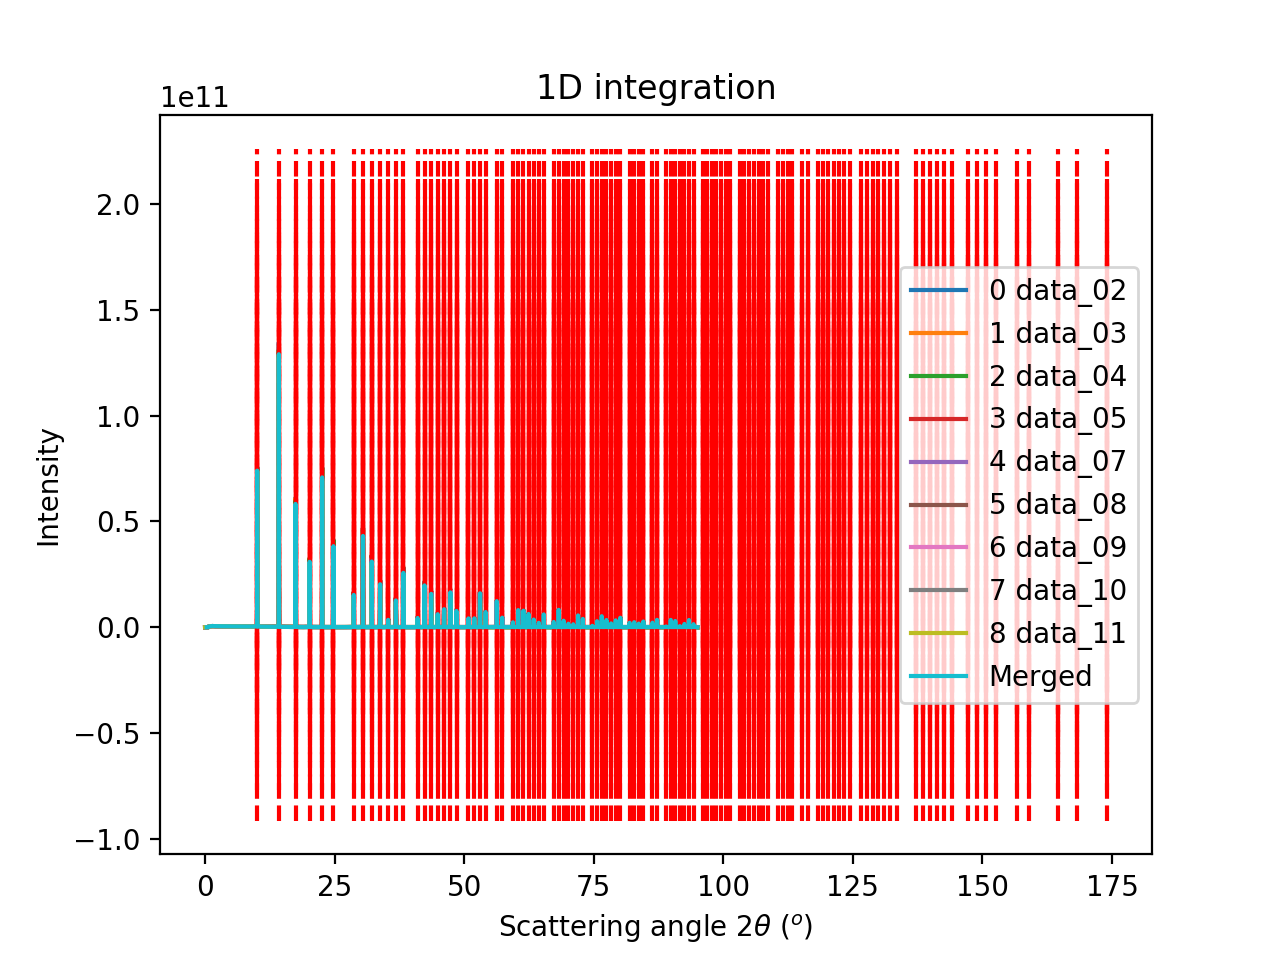

area_pixel=0.05054585816712631 area_sum=0.05084240089824814, Error= -0.005866805745810646
area_pixel=0.05448433978731071 area_sum=0.05460194376540826, Error= -0.002158491385903477
area_pixel=0.05706893234299759 area_sum=0.057097754167008734, Error= -0.0005050352762500703
area_pixel=0.04575136894640419 area_sum=0.046103520693760155, Error= -0.007697075638731046
area_pixel=0.0503875602291064 area_sum=0.05041948354020665, Error= -0.0006335554044510445
area_pixel=0.050887046288177196 area_sum=0.05090400923674137, Error= -0.0003333451202514585
area_pixel=0.047764037615231736 area_sum=0.047787742717740125, Error= -0.0004962960355099896
area_pixel=0.054600585079026764 area_sum=0.05461392295287675, Error= -0.00024428078619822223
area_pixel=0.04398098576245957 area_sum=0.0451093409852144, Error= -0.025655523704017393
area_pixel=0.05413585962925449 area_sum=0.054261047973434326, Error= -0.0023124846458000116
area_pixel=0.05074179597564754 area_sum=0.051022305153632666, Error= -0.0055281681026771

/usr/lib/python3/dist-packages/ipykernel/__main__.py:22: RuntimeWarning: invalid value encountered in true_divide


In [60]:
fig, ax = plt.subplots()
summed, counted, radial = None, None, None

for i in range(9):
    name = ds_names[i]
    ds = data[name]
    gonioref = goniometers[name]
    mg = gonioref.get_mg(position)
    mg.radial_range = (0, 95)
    images = [i.reshape(-1, 1) for i in ds]
    res_mg = mg.integrate1d(images, 50000)
    results[name] = res_mg    
    if summed is None:
        summed = res_mg.sum
        counted = res_mg.count
    else:
        summed += res_mg.sum
        counted += res_mg.count
    radial = res_mg.radial
    jupyter.plot1d(res_mg, label="%i %s"%(i, name), calibrant=LaB6, ax=ax )
    
ax.plot(radial, summed/counted, label="Merged")
ax.legend()
fig.show()    

## Multi-Gonio fit

Can we fit everything togeather ?
Just assume energy and scale parameter of the goniometer are the same for all modules and fit everything.

In [61]:
from scipy.optimize import minimize
class MultiGoniometer:
    def __init__(self, list_of_goniometers,
                param_name_split,
                param_name_common):
        self.nb_gonio = len(list_of_goniometers)
        self.goniometers = list_of_goniometers
        self.names_split = param_name_split
        self.names_common = param_name_common
        self.param = None
        
    def init_param(self):
        param = []
        for gonio in self.goniometers:
            param += list(gonio.param[:len(self.names_split)])
        param += list(gonio.param[len(self.names_split):])
        self.param = numpy.array(param)
    
    def residu2(self, param):
        "Actually performs the calulation of the average of the error squared"
        sumsquare = 0.0
        npt = 0
        for idx, gonio in enumerate(self.goniometers):
            gonio_param = numpy.concatenate((param[len(self.names_split)*idx:len(self.names_split)*(1+idx)],
                                             param[len(self.names_split)*len(self.goniometers):]))
            sumsquare += gonio.residu2(gonio_param)
        return sumsquare

    def chi2(self, param=None):
        """Calculate the average of the square of the error for a given parameter set
        """
        if param is not None:
            return self.residu2(param)
        else:
            if self.param is None:
                self.init_param()
            return self.residu2(self.param)
    def refine2(self, method="slsqp", **options):
        """Geometry refinement tool

        See https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.optimize.minimize.html

        :param method: name of the minimizer
        :param options: options for the minimizer
        """
        if method.lower() in ["simplex", "nelder-mead"]:
            method = "Nelder-Mead"

        former_error = self.chi2()
        print("Cost function before refinement: %s" % former_error)
        param = numpy.asarray(self.param, dtype=numpy.float64)
        print(param)
        res = minimize(self.residu2, param, method=method,
                       tol=1e-12,
                       options=options)
        print(res)
        newparam = res.x
        new_error = res.fun
        print("Cost function after refinement: %s" % new_error)

        if new_error < former_error:
            self.param = newparam
        return self.param
    
    def integrate(self, list_of_dataset, npt=50000, radial_range=(0,100)):
        summed = None
        counted = None
        param = self.param
        for idx, ds in enumerate(list_of_dataset):
            gonio = self.goniometers[idx]
            gonio_param = numpy.concatenate((param[len(self.names_split)*idx:len(self.names_split)*(1+idx)],
                                             param[len(self.names_split)*len(self.goniometers):]))
            print(gonio_param)
            gonio.param = gonio_param
            mg = gonio.get_mg(position)
            mg.radial_range = radial_range
            images = [i.reshape(-1, 1) for i in ds]
            res_mg = mg.integrate1d(images, 50000)
            if summed is None:
                summed = res_mg.sum
                counted = res_mg.count
            else:
                summed += res_mg.sum
                counted += res_mg.count
            radial = res_mg.radial
        res = Integrate1dResult(radial, summed/numpy.maximum(counted, 1e-10))
        res._set_unit(res_mg.unit)
        res._set_count(counted)
        res._set_sum(summed)
        return res

In [62]:
multigonio = MultiGoniometer([goniometers[ds_names[i]] for i in range(9)],
                 ["dist", "poni1", "poni2", "rot1", "offset"], 
                ["scale", "nrj"])


In [63]:
%time print(multigonio.chi2())
multigonio.param = numpy.array([ 7.20594053e-01,  3.22408604e-02,  4.05228023e-03, -2.75578440e-05,
       -8.27999414e+01,  7.20612302e-01,  3.36369797e-02,  4.02094516e-03,
       -1.74996556e-05, -7.71999791e+01,  7.20636130e-01,  3.47920978e-02,
        4.01341931e-03, -1.21330600e-05, -7.15999090e+01,  7.20757808e-01,
        3.33850817e-02,  3.95036100e-03,  3.46517345e-05, -6.57999267e+01,
        7.20813915e-01,  3.22167822e-02,  3.97128822e-03,  2.00055269e-05,
       -6.00000525e+01,  7.20881596e-01,  3.33801850e-02,  3.97760147e-03,
        1.47074593e-05, -5.43998157e+01,  7.21048510e-01,  3.22346939e-02,
        4.02104962e-03, -1.69519259e-05, -4.85998856e+01,  7.21074630e-01,
        3.08484557e-02,  4.09385968e-03, -6.91378973e-05, -4.27999030e+01,
        7.21154891e-01,  3.20619921e-02,  4.24950906e-03, -1.81328256e-04,
       -3.71999987e+01,  9.99038595e-01,  1.70266104e+01])
%time print(multigonio.chi2())


8.60311201704e-09
CPU times: user 33.5 s, sys: 43.7 ms, total: 33.5 s
Wall time: 843 ms
6.13959836202e-09
CPU times: user 1min 1s, sys: 16.4 ms, total: 1min 1s
Wall time: 1.57 s


In [64]:
%time multigonio.refine2()

Cost function before refinement: 6.13959836202e-09
[  7.20594053e-01   3.22408604e-02   4.05228023e-03  -2.75578440e-05
  -8.27999414e+01   7.20612302e-01   3.36369797e-02   4.02094516e-03
  -1.74996556e-05  -7.71999791e+01   7.20636130e-01   3.47920978e-02
   4.01341931e-03  -1.21330600e-05  -7.15999090e+01   7.20757808e-01
   3.33850817e-02   3.95036100e-03   3.46517345e-05  -6.57999267e+01
   7.20813915e-01   3.22167822e-02   3.97128822e-03   2.00055269e-05
  -6.00000525e+01   7.20881596e-01   3.33801850e-02   3.97760147e-03
   1.47074593e-05  -5.43998157e+01   7.21048510e-01   3.22346939e-02
   4.02104962e-03  -1.69519259e-05  -4.85998856e+01   7.21074630e-01
   3.08484557e-02   4.09385968e-03  -6.91378973e-05  -4.27999030e+01
   7.21154891e-01   3.20619921e-02   4.24950906e-03  -1.81328256e-04
  -3.71999987e+01   9.99038595e-01   1.70266104e+01]
     fun: 6.1395983620232986e-09
     jac: array([  5.90883473e-08,  -1.08561671e-07,  -2.52646911e-08,
         1.79747064e-08,  -1.7292

array([  7.20594053e-01,   3.22408604e-02,   4.05228023e-03,
        -2.75578440e-05,  -8.27999414e+01,   7.20612302e-01,
         3.36369797e-02,   4.02094516e-03,  -1.74996556e-05,
        -7.71999791e+01,   7.20636130e-01,   3.47920978e-02,
         4.01341931e-03,  -1.21330600e-05,  -7.15999090e+01,
         7.20757808e-01,   3.33850817e-02,   3.95036100e-03,
         3.46517345e-05,  -6.57999267e+01,   7.20813915e-01,
         3.22167822e-02,   3.97128822e-03,   2.00055269e-05,
        -6.00000525e+01,   7.20881596e-01,   3.33801850e-02,
         3.97760147e-03,   1.47074593e-05,  -5.43998157e+01,
         7.21048510e-01,   3.22346939e-02,   4.02104962e-03,
        -1.69519259e-05,  -4.85998856e+01,   7.21074630e-01,
         3.08484557e-02,   4.09385968e-03,  -6.91378973e-05,
        -4.27999030e+01,   7.21154891e-01,   3.20619921e-02,
         4.24950906e-03,  -1.81328256e-04,  -3.71999987e+01,
         9.99038595e-01,   1.70266104e+01])

In [65]:
LaB6_new = get_calibrant("LaB6")
LaB6_new.wavelength = 1e-10*hc/multigonio.param[-1]
print(LaB6,"\n", LaB6_new)

LaB6 Calibrant with 109 reflections at wavelength 7.281789761742598e-11 
 LaB6 Calibrant at wavelength 7.281789768115395e-11


In [66]:
%time res = multigonio.integrate([data[ds_names[i]] for i in range(9)])

[  7.20594053e-01   3.22408604e-02   4.05228023e-03  -2.75578440e-05
  -8.27999414e+01   9.99038595e-01   1.70266104e+01]
area_pixel=0.053413862261281864 area_sum=0.055214882933248166, Error= -0.033718225863472326
area_pixel=0.045333067243413794 area_sum=0.04986384765291535, Error= -0.09994427213966664
area_pixel=0.03918749031126367 area_sum=0.04563241935519968, Error= -0.16446393970995232
area_pixel=0.04641997394066166 area_sum=0.05056017758649528, Error= -0.0891901329183427
area_pixel=0.04963019502342725 area_sum=0.052784706110374724, Error= -0.06356032019335069
area_pixel=0.041808779534353135 area_sum=0.04729034242949584, Error= -0.13111033032281305
area_pixel=0.053529818242976646 area_sum=0.05553764984245543, Error= -0.03750865714441734
area_pixel=0.05746249488342414 area_sum=0.05828939512131753, Error= -0.014390259935127214
area_pixel=0.03804626259786659 area_sum=0.04468957516491201, Error= -0.17461143653615904
area_pixel=0.0579645518625469 area_sum=0.05860457337617547, Error= -0.

/usr/lib/python3/dist-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


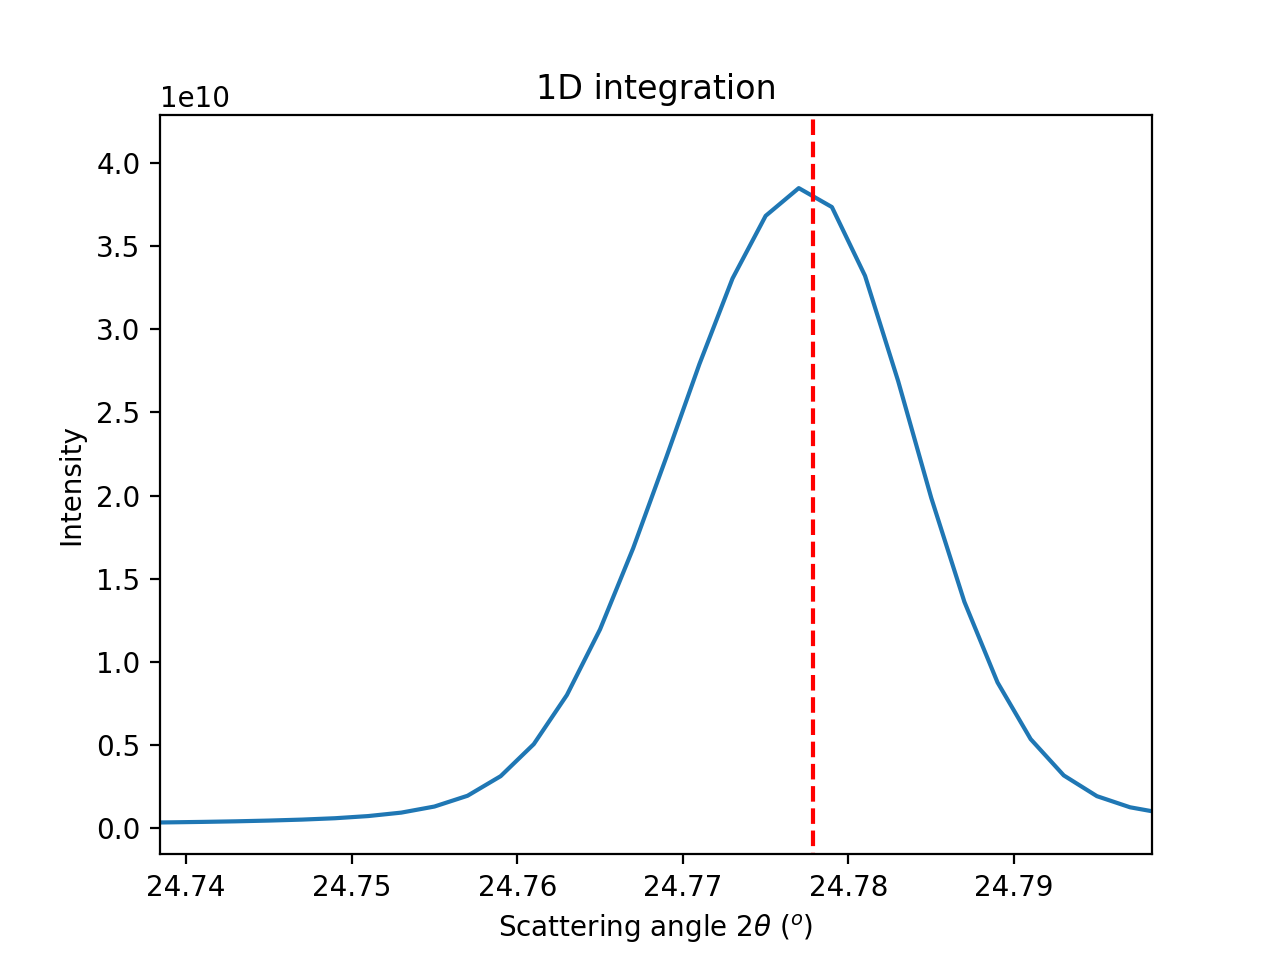

In [67]:
ax = jupyter.plot1d(res, calibrant=LaB6_new)
ax.figure.show()

/usr/lib/python3/dist-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


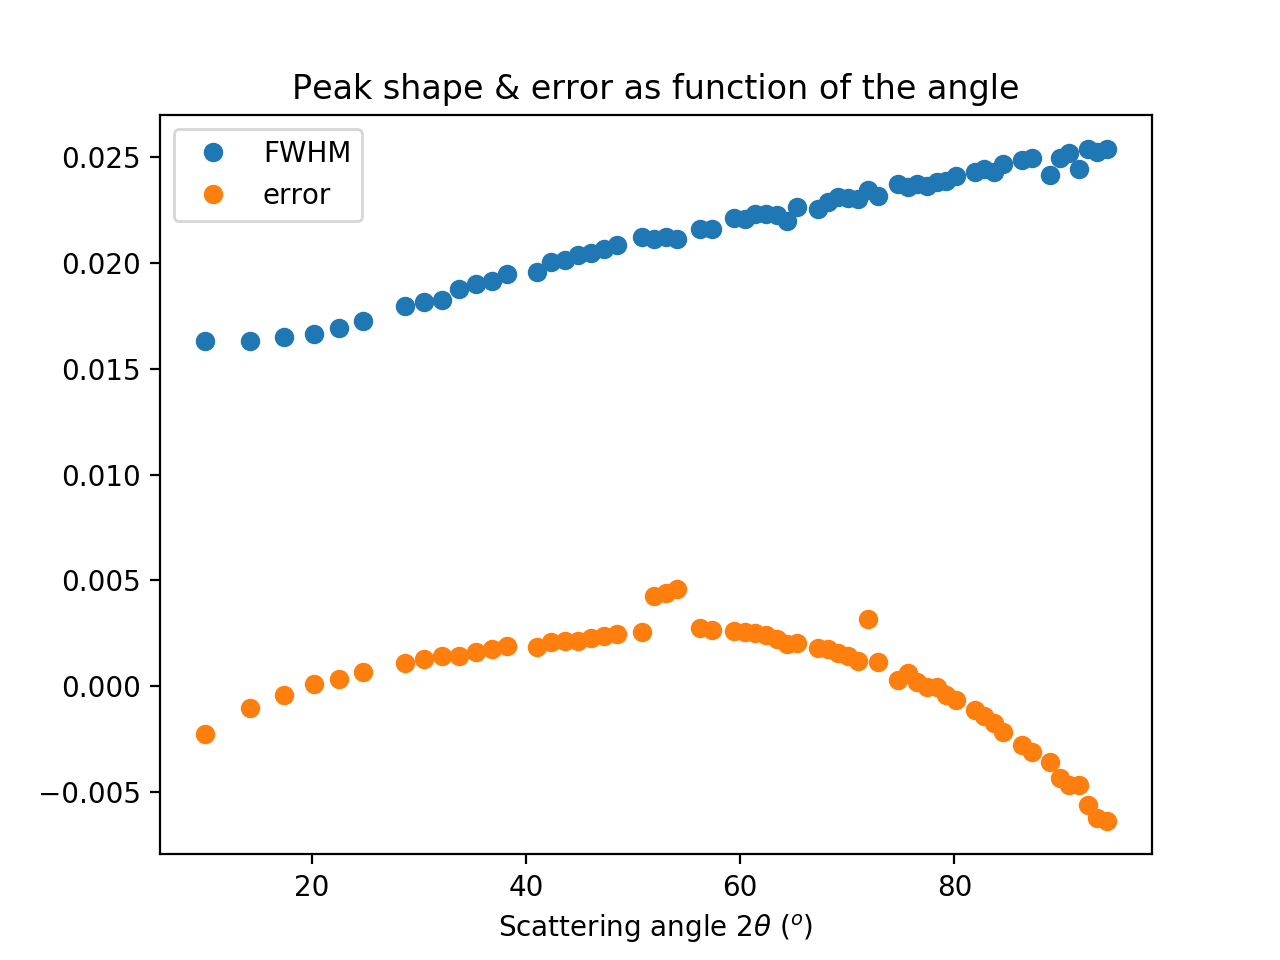

28457
68 60


In [68]:
fig, ax = plt.subplots()
ax.plot(*calc_fwhm(res, LaB6_new, 10, 95), "o", label="FWHM")
ax.plot(*calc_peak_error(res, LaB6_new, 10, 95), "o", label="error")
ax.set_title("Peak shape & error as function of the angle")
ax.set_xlabel(res.unit.label)
ax.legend()
fig.show()

In [69]:
print("total run time: ", time.time()-start_time)

total run time:  397.32472920417786


## Conclusion
The calibration works and the FWHM of every single peak is pretty small: 0.02°. 
The geometry has been refined with the wavelength: 
The goniometer scale parameter refines to 0.999 instead of 1 and the wavelength is fitted with a change at the 5th digit which is pretty precise.

In [103]:
# remove the nan values
intensity = summed/counted
summ = numpy.vstack([radial, intensity/1000.])[:,~numpy.isnan(intensity)]
numpy.savetxt("summ_1555.dat",summ.T)
numpy.savetxt("calib_1555.cal", multigonio.param)

/usr/lib/python3/dist-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


In [102]:
multigonio.param

array([  7.20594053e-01,   3.22408604e-02,   4.05228023e-03,
        -2.75578440e-05,  -8.27999414e+01,   7.20612302e-01,
         3.36369797e-02,   4.02094516e-03,  -1.74996556e-05,
        -7.71999791e+01,   7.20636130e-01,   3.47920978e-02,
         4.01341931e-03,  -1.21330600e-05,  -7.15999090e+01,
         7.20757808e-01,   3.33850817e-02,   3.95036100e-03,
         3.46517345e-05,  -6.57999267e+01,   7.20813915e-01,
         3.22167822e-02,   3.97128822e-03,   2.00055269e-05,
        -6.00000525e+01,   7.20881596e-01,   3.33801850e-02,
         3.97760147e-03,   1.47074593e-05,  -5.43998157e+01,
         7.21048510e-01,   3.22346939e-02,   4.02104962e-03,
        -1.69519259e-05,  -4.85998856e+01,   7.21074630e-01,
         3.08484557e-02,   4.09385968e-03,  -6.91378973e-05,
        -4.27999030e+01,   7.21154891e-01,   3.20619921e-02,
         4.24950906e-03,  -1.81328256e-04,  -3.71999987e+01,
         9.99038595e-01,   1.70266104e+01])

In [1]:
from tkinter.filedialog import askopenfilename

In [7]:
askopenfilename()

'/home/experiences/instrumentation/picca/pyFAI/doc/source/usage/tutorial/Soleil/calib_1.json'

In [4]:
f = askopenfilename()

In [3]:
f

'/home/experiences/instrumentation/picca/pyFAI/doc/source/usage/tutorial/Soleil/calib_0.json'